***Sina Hatami 5447389<br>
Shayan Alvansazyazdi 5447411***

# Lab. 3 - GANs

In this lab we will practice the use of Generative Adversarial Networks (GANs) on images. The choice of such data is guided by the fact the generated samples can be easily visually inspected to appreciate the quality.


![picture](https://drive.google.com/uc?id=1BEXEPdR-cwj84MbbsDGlQQgUzFd30KRe)

In [1]:
# we start importing some libraries
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal

from matplotlib import pyplot as plt
import numpy as np
from math import sqrt

In [2]:
# we load the data, the fashion_mnist dataset, and we visualize some examples
(X_train, _), (_, _) = fashion_mnist.load_data()

print('X_train:', X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)


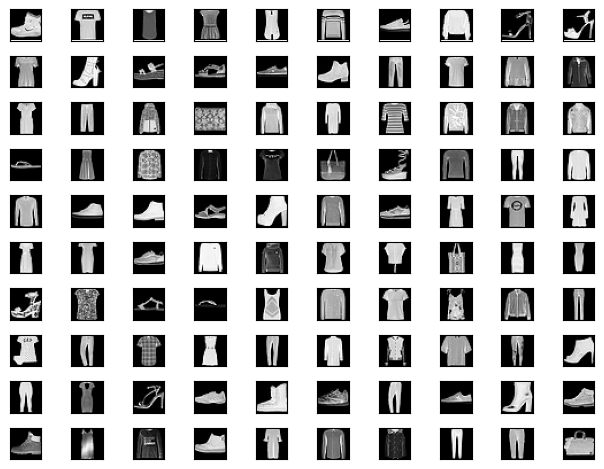

In [3]:
# we visualize some data

for i in range(0, 100):
    plt.subplot(10, 10, 1 + i, xticks=[], yticks=[])
    plt.imshow(np.squeeze(X_train[i]),cmap='gray')
    
plt.tight_layout()

In [4]:
# the generator is using tanh activation in the last layer, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

In [5]:
# A function to generate random inputs
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [6]:
# A function to sample a training point
def sample_real_data(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [7]:
# A function to generate a fake input from a random point
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [8]:
# To print a summary of the training
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [9]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        plt.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

In [10]:
# define the structure of the discriminator (binary classifier real-fake)

def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [11]:
# build the discriminator

discriminator = define_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# define the generator 

def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [13]:
# build the generator
latent_dim = 5
generator = define_generator(latent_dim)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 256)               1536      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0   

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
# define the GANs architecture

def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [15]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 256)               1536      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0   

In [16]:
def plot_loss(d_loss,g_loss, dim):
    plt.close()
    plt.figure(figsize=dim)
    plt.plot(d_loss)
    plt.plot(g_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(['Discriminator', 'Generator'], loc='upper right')
    plt.show()
    
def plot_acc(d_acc,g_acc, dim):
    plt.close()
    plt.figure(figsize=dim)
    plt.plot(d_acc)
    plt.plot(g_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.legend(['Discriminator', 'Generator'], loc='upper right')
    plt.show()

In [17]:
# Training function

def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    
    d_loss_vec = []
    g_loss_vec = []
    
    d_acc_vec = [];
    g_acc_vec = [];
    
    for i in range(n_steps):
        
        d_loss_b = []
        g_loss_b = []
    
        d_acc_b = [];
        g_acc_b = [];
        
        X_real, y_real = sample_real_data(X_train, n_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        
        d_loss_b.append((d_loss_r + d_loss_f)/2)
        d_acc_b.append((d_acc_r + d_acc_r)/2)
       
        
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        
        g_loss_b.append(g_loss)
        g_acc_b.append(g_acc)
        
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            
            summarize_performance(i, g_model, latent_dim)
            
            d_loss_vec.append(np.mean(d_loss_b))
            g_loss_vec.append(np.mean(g_loss_b))
            d_acc_vec.append(np.mean(d_acc_b))
            g_acc_vec.append(np.mean(g_acc_b))
            
            d_loss_b = []
            g_loss_b = []
    
            d_acc_b = [];
            g_acc_b = [];
            
            plot_loss(d_loss_vec,g_loss_vec, (6,4))
            plot_acc(d_acc_vec,g_acc_vec, (6,4))
            

2/2 [==============================] - 0s 14ms/step
>1, dr[0.598,0.672], df[0.698,0.000], g[0.690,1.000]
2/2 [==============================] - 0s 16ms/step
>2, dr[0.057,1.000], df[0.700,0.000], g[0.689,1.000]
2/2 [==============================] - 0s 11ms/step
>3, dr[0.030,1.000], df[0.700,0.000], g[0.690,0.984]
2/2 [==============================] - 0s 11ms/step
>4, dr[0.016,1.000], df[0.703,0.000], g[0.688,0.953]
2/2 [==============================] - 0s 10ms/step
>5, dr[0.010,1.000], df[0.707,0.000], g[0.686,0.922]
2/2 [==============================] - 0s 11ms/step
>6, dr[0.008,1.000], df[0.714,0.000], g[0.679,0.969]
2/2 [==============================] - 0s 9ms/step
>7, dr[0.006,1.000], df[0.721,0.000], g[0.673,0.984]
2/2 [==============================] - 0s 10ms/step
>8, dr[0.005,1.000], df[0.735,0.000], g[0.661,1.000]
2/2 [==============================] - 0s 8ms/step
>9, dr[0.005,1.000], df[0.751,0.000], g[0.655,0.984]
2/2 [==============================] - 0s 10ms/step
>10, 

>Saved: model_0937.h5


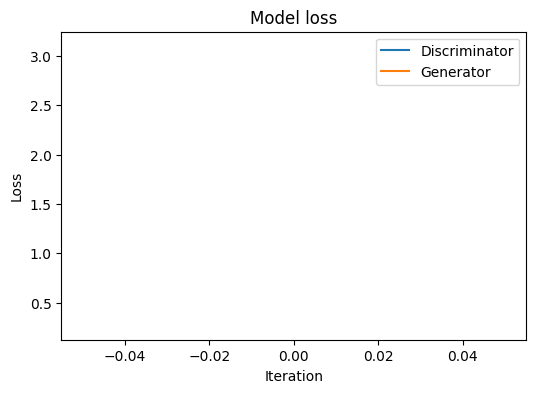

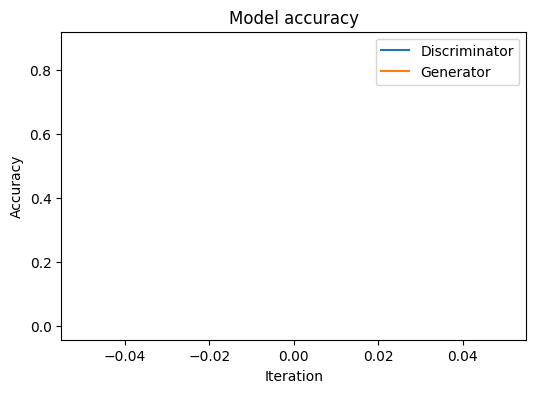

2/2 [==============================] - 0s 10ms/step
>938, dr[0.255,0.875], df[0.306,0.891], g[3.259,0.000]
2/2 [==============================] - 0s 15ms/step
>939, dr[0.231,0.891], df[0.170,0.984], g[3.332,0.000]
2/2 [==============================] - 0s 13ms/step
>940, dr[0.295,0.875], df[0.543,0.781], g[3.991,0.000]
2/2 [==============================] - 0s 11ms/step
>941, dr[0.621,0.703], df[0.151,1.000], g[2.586,0.016]
2/2 [==============================] - 0s 16ms/step
>942, dr[0.412,0.734], df[0.576,0.812], g[3.134,0.031]
2/2 [==============================] - 0s 12ms/step
>943, dr[0.286,0.859], df[0.169,0.953], g[3.118,0.000]
2/2 [==============================] - 0s 11ms/step
>944, dr[0.381,0.812], df[0.281,0.969], g[2.758,0.000]
2/2 [==============================] - 0s 11ms/step
>945, dr[0.129,0.938], df[0.175,0.984], g[2.995,0.000]
2/2 [==============================] - 0s 12ms/step
>946, dr[0.231,0.859], df[0.276,0.922], g[3.485,0.000]
2/2 [==============================] 

>Saved: model_1874.h5


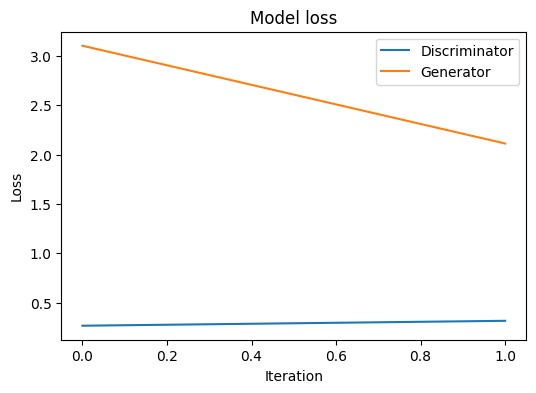

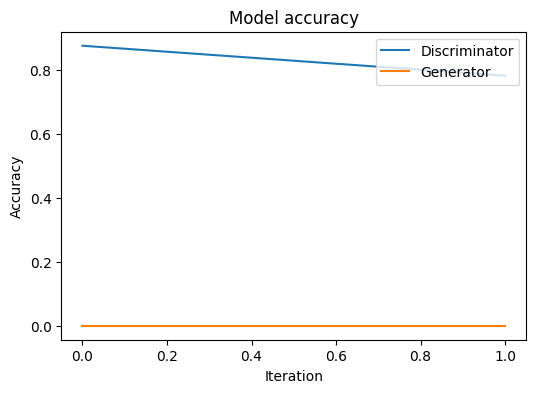

2/2 [==============================] - 0s 13ms/step
>1875, dr[0.393,0.766], df[0.292,0.938], g[2.085,0.000]
2/2 [==============================] - 0s 12ms/step
>1876, dr[0.453,0.719], df[0.415,0.828], g[2.141,0.016]
2/2 [==============================] - 0s 15ms/step
>1877, dr[0.607,0.688], df[0.240,0.984], g[2.112,0.016]
2/2 [==============================] - 0s 11ms/step
>1878, dr[0.593,0.641], df[0.427,0.891], g[1.863,0.000]
2/2 [==============================] - 0s 14ms/step
>1879, dr[0.210,0.859], df[0.365,0.891], g[2.306,0.000]
2/2 [==============================] - 0s 19ms/step
>1880, dr[0.477,0.750], df[0.287,0.969], g[2.179,0.000]
2/2 [==============================] - 0s 13ms/step
>1881, dr[0.286,0.828], df[0.265,0.969], g[2.417,0.000]
2/2 [==============================] - 0s 14ms/step
>1882, dr[0.284,0.844], df[0.208,0.969], g[2.206,0.031]
2/2 [==============================] - 0s 17ms/step
>1883, dr[0.289,0.828], df[0.317,0.953], g[2.339,0.016]
2/2 [=======================

>Saved: model_2811.h5


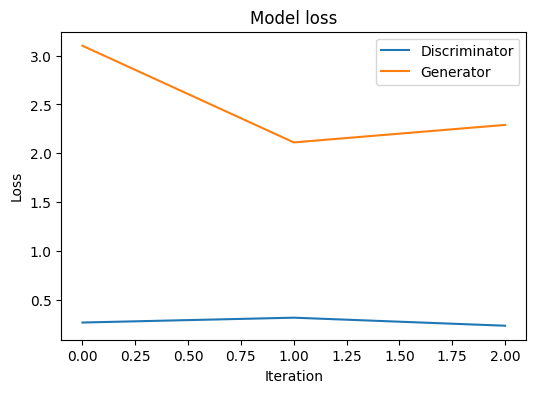

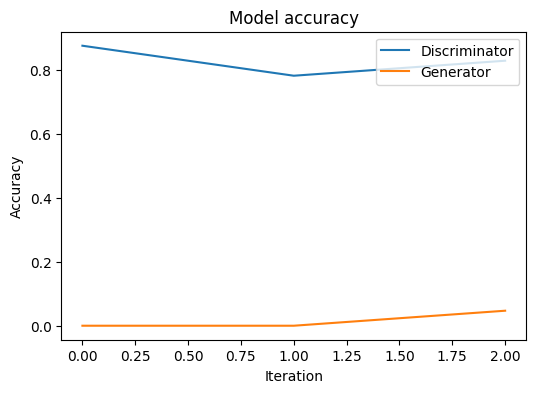

2/2 [==============================] - 0s 16ms/step
>2812, dr[0.423,0.766], df[0.554,0.766], g[2.159,0.047]
2/2 [==============================] - 0s 12ms/step
>2813, dr[0.374,0.828], df[0.286,0.875], g[2.325,0.047]
2/2 [==============================] - 0s 16ms/step
>2814, dr[0.493,0.766], df[0.353,0.859], g[2.313,0.031]
2/2 [==============================] - 0s 15ms/step
>2815, dr[0.402,0.766], df[0.357,0.859], g[2.527,0.000]
2/2 [==============================] - 0s 16ms/step
>2816, dr[0.357,0.781], df[0.360,0.922], g[2.405,0.016]
2/2 [==============================] - 0s 13ms/step
>2817, dr[0.496,0.750], df[0.250,0.969], g[2.116,0.016]
2/2 [==============================] - 0s 12ms/step
>2818, dr[0.347,0.781], df[0.394,0.797], g[2.349,0.016]
2/2 [==============================] - 0s 12ms/step
>2819, dr[0.434,0.766], df[0.214,0.984], g[2.194,0.016]
2/2 [==============================] - 0s 11ms/step
>2820, dr[0.414,0.781], df[0.477,0.797], g[2.536,0.016]
2/2 [=======================

>Saved: model_3748.h5


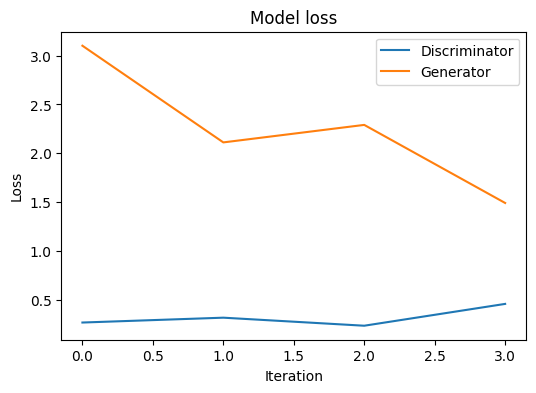

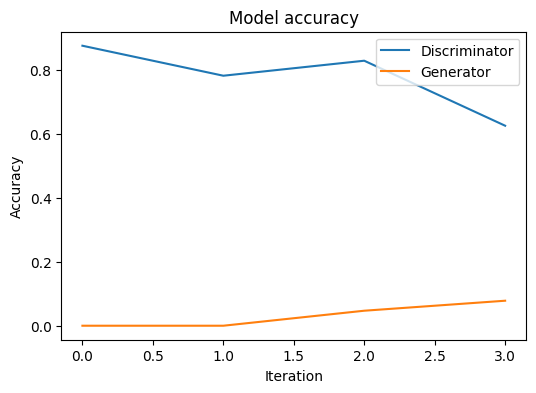

2/2 [==============================] - 0s 13ms/step
>3749, dr[0.448,0.719], df[0.425,0.875], g[1.692,0.031]
2/2 [==============================] - 0s 15ms/step
>3750, dr[0.459,0.750], df[0.312,0.953], g[1.636,0.078]
2/2 [==============================] - 0s 17ms/step
>3751, dr[0.317,0.828], df[0.428,0.828], g[1.949,0.016]
2/2 [==============================] - 0s 15ms/step
>3752, dr[0.510,0.719], df[0.367,0.906], g[1.662,0.062]
2/2 [==============================] - 0s 14ms/step
>3753, dr[0.383,0.766], df[0.416,0.859], g[1.811,0.062]
2/2 [==============================] - 0s 11ms/step
>3754, dr[0.509,0.719], df[0.401,0.844], g[1.665,0.094]
2/2 [==============================] - 0s 11ms/step
>3755, dr[0.496,0.703], df[0.393,0.875], g[1.668,0.047]
2/2 [==============================] - 0s 11ms/step
>3756, dr[0.492,0.719], df[0.480,0.750], g[1.558,0.125]
2/2 [==============================] - 0s 14ms/step
>3757, dr[0.458,0.734], df[0.473,0.891], g[1.689,0.094]
2/2 [=======================

>Saved: model_4685.h5


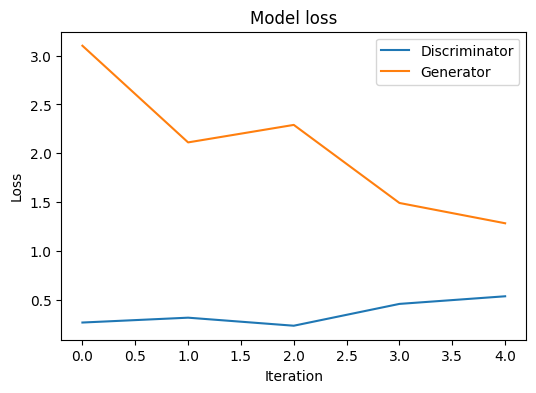

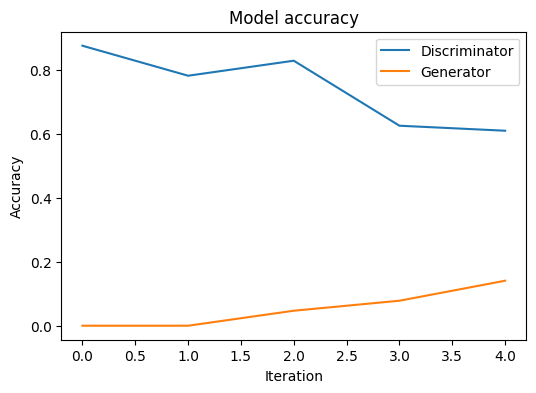

2/2 [==============================] - 0s 11ms/step
>4686, dr[0.516,0.688], df[0.547,0.828], g[1.340,0.094]
2/2 [==============================] - 0s 13ms/step
>4687, dr[0.491,0.734], df[0.478,0.875], g[1.276,0.094]
2/2 [==============================] - 0s 16ms/step
>4688, dr[0.469,0.703], df[0.436,0.906], g[1.357,0.109]
2/2 [==============================] - 0s 25ms/step
>4689, dr[0.445,0.750], df[0.448,0.844], g[1.508,0.016]
2/2 [==============================] - 0s 15ms/step
>4690, dr[0.479,0.688], df[0.446,0.906], g[1.308,0.109]
2/2 [==============================] - 0s 13ms/step
>4691, dr[0.536,0.672], df[0.414,0.875], g[1.414,0.062]
2/2 [==============================] - 0s 13ms/step
>4692, dr[0.567,0.625], df[0.525,0.844], g[1.271,0.156]
2/2 [==============================] - 0s 13ms/step
>4693, dr[0.529,0.641], df[0.499,0.828], g[1.434,0.047]
2/2 [==============================] - 0s 15ms/step
>4694, dr[0.571,0.656], df[0.545,0.797], g[1.479,0.062]
2/2 [=======================

>Saved: model_5622.h5


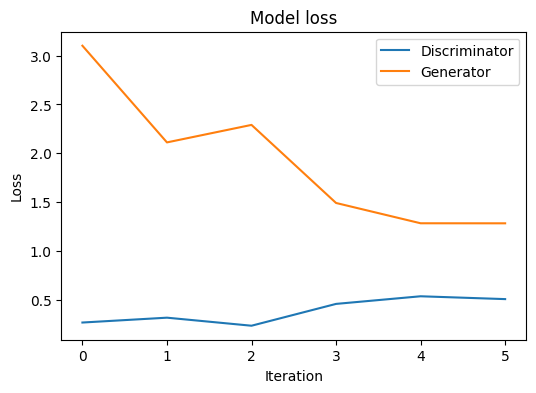

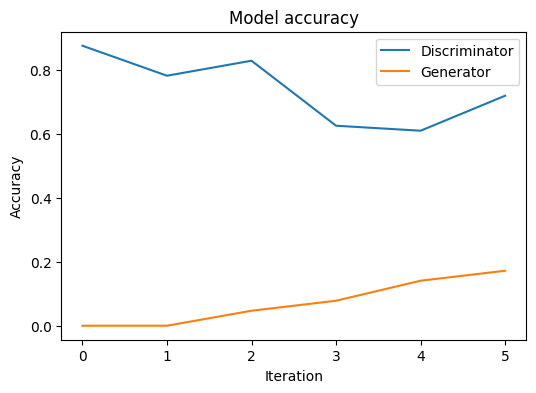

2/2 [==============================] - 0s 14ms/step
>5623, dr[0.623,0.578], df[0.434,0.891], g[1.275,0.094]
2/2 [==============================] - 0s 15ms/step
>5624, dr[0.605,0.625], df[0.524,0.812], g[1.213,0.141]
2/2 [==============================] - 0s 13ms/step
>5625, dr[0.479,0.703], df[0.480,0.859], g[1.378,0.125]
2/2 [==============================] - 0s 24ms/step
>5626, dr[0.479,0.719], df[0.633,0.734], g[1.394,0.078]
2/2 [==============================] - 0s 14ms/step
>5627, dr[0.551,0.719], df[0.554,0.781], g[1.352,0.094]
2/2 [==============================] - 0s 19ms/step
>5628, dr[0.594,0.562], df[0.568,0.781], g[1.564,0.047]
2/2 [==============================] - 0s 13ms/step
>5629, dr[0.528,0.719], df[0.473,0.828], g[1.402,0.078]
2/2 [==============================] - 0s 18ms/step
>5630, dr[0.571,0.656], df[0.491,0.766], g[1.457,0.031]
2/2 [==============================] - 0s 15ms/step
>5631, dr[0.520,0.719], df[0.459,0.875], g[1.379,0.109]
2/2 [=======================

>Saved: model_6559.h5


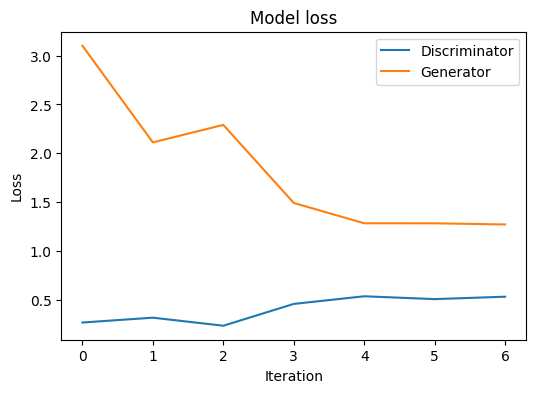

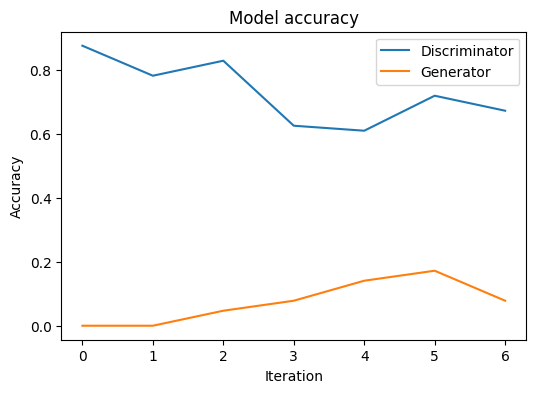

2/2 [==============================] - 0s 15ms/step
>6560, dr[0.638,0.578], df[0.483,0.812], g[1.291,0.047]
2/2 [==============================] - 0s 13ms/step
>6561, dr[0.514,0.641], df[0.452,0.922], g[1.234,0.141]
2/2 [==============================] - 0s 13ms/step
>6562, dr[0.645,0.578], df[0.610,0.766], g[1.271,0.078]
2/2 [==============================] - 0s 12ms/step
>6563, dr[0.424,0.750], df[0.557,0.750], g[1.267,0.078]
2/2 [==============================] - 0s 13ms/step
>6564, dr[0.584,0.625], df[0.491,0.906], g[1.329,0.094]
2/2 [==============================] - 0s 17ms/step
>6565, dr[0.560,0.641], df[0.656,0.672], g[1.283,0.062]
2/2 [==============================] - 0s 15ms/step
>6566, dr[0.615,0.609], df[0.427,0.875], g[1.306,0.094]
2/2 [==============================] - 0s 20ms/step
>6567, dr[0.549,0.625], df[0.450,0.859], g[1.351,0.047]
2/2 [==============================] - 0s 17ms/step
>6568, dr[0.601,0.594], df[0.631,0.734], g[1.169,0.094]
2/2 [=======================

>Saved: model_7496.h5


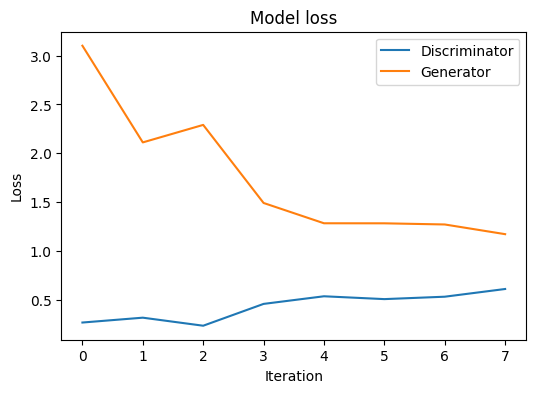

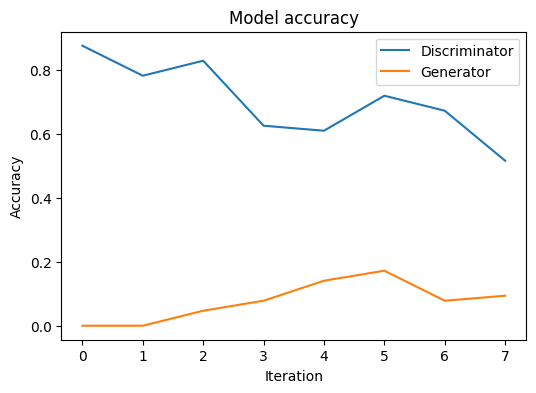

2/2 [==============================] - 0s 15ms/step
>7497, dr[0.554,0.656], df[0.547,0.766], g[1.121,0.172]
2/2 [==============================] - 0s 13ms/step
>7498, dr[0.568,0.641], df[0.542,0.797], g[1.249,0.062]
2/2 [==============================] - 0s 15ms/step
>7499, dr[0.698,0.516], df[0.536,0.797], g[1.209,0.078]
2/2 [==============================] - 0s 16ms/step
>7500, dr[0.550,0.594], df[0.569,0.781], g[1.114,0.125]
2/2 [==============================] - 0s 12ms/step
>7501, dr[0.606,0.578], df[0.653,0.703], g[1.203,0.062]
2/2 [==============================] - 0s 14ms/step
>7502, dr[0.538,0.609], df[0.476,0.859], g[1.192,0.062]
2/2 [==============================] - 0s 12ms/step
>7503, dr[0.472,0.719], df[0.539,0.797], g[1.292,0.094]
2/2 [==============================] - 0s 12ms/step
>7504, dr[0.743,0.500], df[0.601,0.750], g[1.269,0.078]
2/2 [==============================] - 0s 11ms/step
>7505, dr[0.592,0.594], df[0.464,0.891], g[1.176,0.094]
2/2 [=======================

>Saved: model_8433.h5


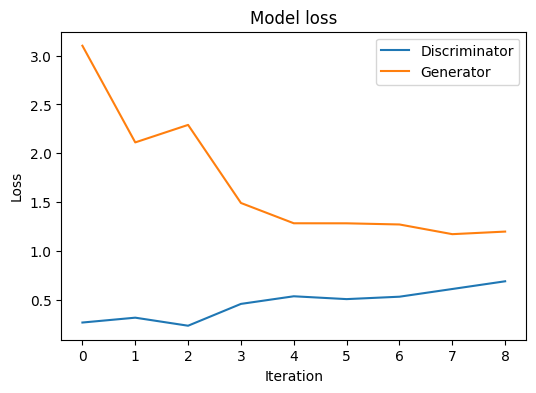

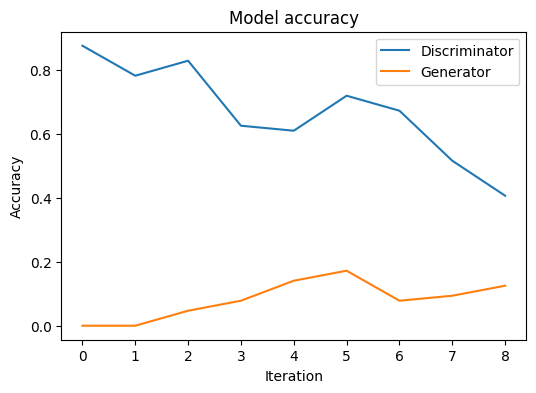

2/2 [==============================] - 0s 11ms/step
>8434, dr[0.628,0.578], df[0.567,0.781], g[1.188,0.094]
2/2 [==============================] - 0s 15ms/step
>8435, dr[0.640,0.594], df[0.476,0.922], g[1.139,0.188]
2/2 [==============================] - 0s 16ms/step
>8436, dr[0.655,0.547], df[0.555,0.781], g[1.195,0.125]
2/2 [==============================] - 0s 15ms/step
>8437, dr[0.542,0.656], df[0.517,0.812], g[1.197,0.125]
2/2 [==============================] - 0s 19ms/step
>8438, dr[0.577,0.703], df[0.524,0.781], g[1.095,0.094]
2/2 [==============================] - 0s 10ms/step
>8439, dr[0.555,0.594], df[0.639,0.812], g[1.233,0.047]
2/2 [==============================] - 0s 12ms/step
>8440, dr[0.507,0.734], df[0.455,0.922], g[1.159,0.172]
2/2 [==============================] - 0s 11ms/step
>8441, dr[0.657,0.562], df[0.550,0.797], g[1.180,0.078]
2/2 [==============================] - 0s 18ms/step
>8442, dr[0.584,0.625], df[0.543,0.812], g[1.313,0.031]
2/2 [=======================

>Saved: model_9370.h5


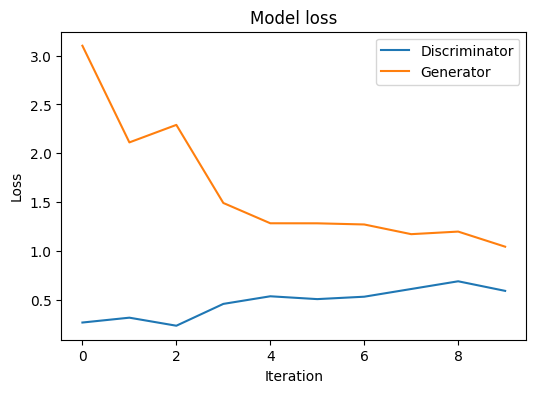

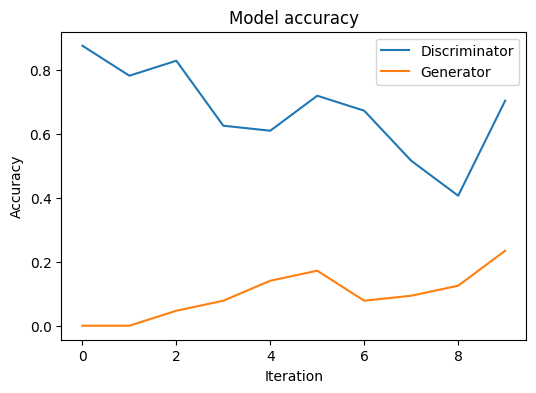

In [18]:
latent_dim = 5
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=64)


In [ ]:
# load one of the saved models and try and generate fake samples
model = load_model('model_9370.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

2/2 [==============================] - 0s 11ms/step
>1, dr[0.443,0.766], df[0.523,0.812], g[1.099,0.141]
2/2 [==============================] - 0s 10ms/step
>2, dr[0.477,0.703], df[0.600,0.719], g[1.211,0.078]
2/2 [==============================] - 0s 12ms/step
>3, dr[0.604,0.625], df[0.455,0.859], g[1.130,0.109]
2/2 [==============================] - 0s 16ms/step
>4, dr[0.616,0.594], df[0.514,0.828], g[1.119,0.078]
2/2 [==============================] - 0s 14ms/step
>5, dr[0.627,0.562], df[0.653,0.719], g[1.139,0.156]
2/2 [==============================] - 0s 12ms/step
>6, dr[0.525,0.719], df[0.568,0.797], g[1.146,0.141]
2/2 [==============================] - 0s 12ms/step
>7, dr[0.519,0.688], df[0.555,0.781], g[1.130,0.141]
2/2 [==============================] - 0s 12ms/step
>8, dr[0.624,0.578], df[0.485,0.875], g[1.060,0.156]
2/2 [==============================] - 0s 10ms/step
>9, dr[0.553,0.672], df[0.617,0.719], g[1.178,0.156]
2/2 [==============================] - 0s 11ms/step
>10

>Saved: model_0937.h5


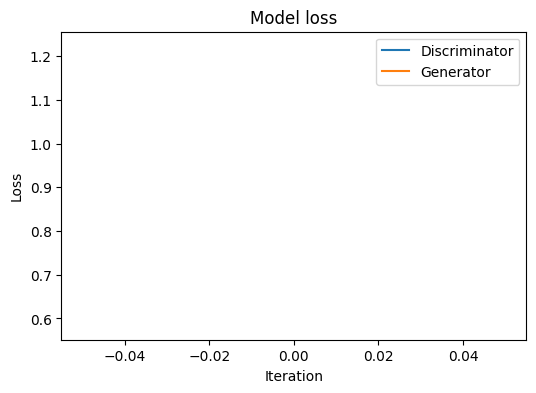

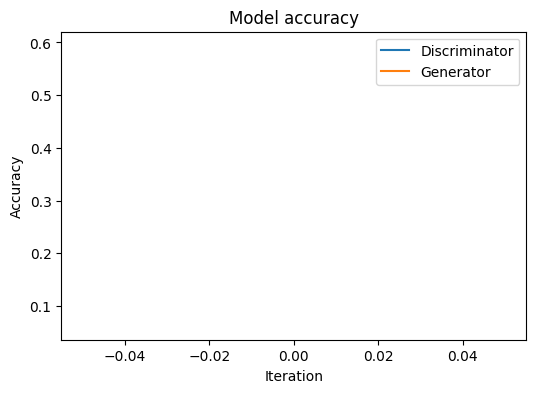

2/2 [==============================] - 0s 13ms/step
>938, dr[0.665,0.469], df[0.646,0.688], g[1.146,0.109]
2/2 [==============================] - 0s 13ms/step
>939, dr[0.567,0.656], df[0.476,0.906], g[1.135,0.109]
2/2 [==============================] - 0s 20ms/step
>940, dr[0.558,0.594], df[0.496,0.859], g[1.154,0.094]
2/2 [==============================] - 0s 11ms/step
>941, dr[0.524,0.625], df[0.546,0.812], g[1.120,0.109]
2/2 [==============================] - 0s 18ms/step
>942, dr[0.629,0.547], df[0.509,0.828], g[1.123,0.078]
2/2 [==============================] - 0s 11ms/step
>943, dr[0.526,0.656], df[0.653,0.719], g[1.193,0.125]
2/2 [==============================] - 0s 17ms/step
>944, dr[0.619,0.562], df[0.606,0.734], g[1.094,0.094]
2/2 [==============================] - 0s 18ms/step
>945, dr[0.630,0.594], df[0.465,0.875], g[1.095,0.125]
2/2 [==============================] - 0s 14ms/step
>946, dr[0.623,0.531], df[0.584,0.781], g[1.031,0.234]
2/2 [==============================] 

>Saved: model_1874.h5


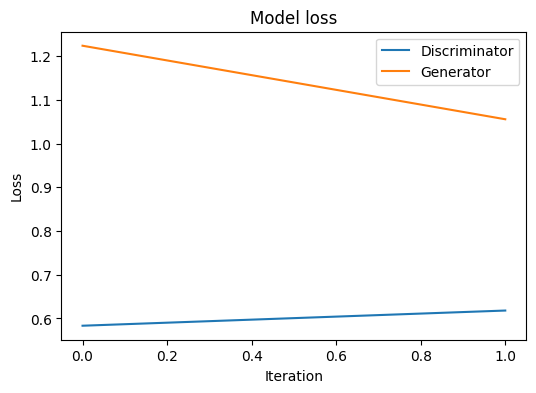

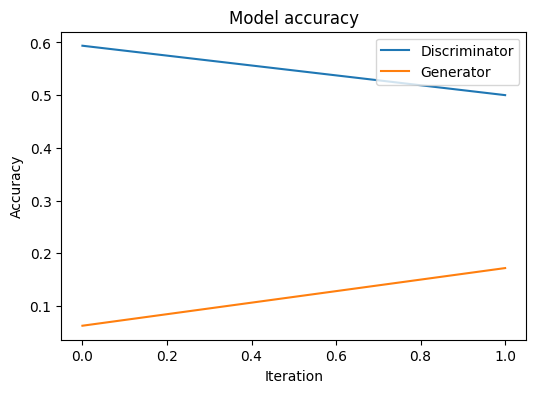

2/2 [==============================] - 0s 18ms/step
>1875, dr[0.617,0.609], df[0.716,0.625], g[1.098,0.078]
2/2 [==============================] - 0s 16ms/step
>1876, dr[0.541,0.641], df[0.572,0.797], g[1.230,0.031]
2/2 [==============================] - 0s 17ms/step
>1877, dr[0.550,0.734], df[0.526,0.844], g[1.083,0.141]
2/2 [==============================] - 0s 16ms/step
>1878, dr[0.635,0.625], df[0.601,0.734], g[1.118,0.078]
2/2 [==============================] - 0s 13ms/step
>1879, dr[0.594,0.578], df[0.515,0.797], g[1.158,0.172]
2/2 [==============================] - 0s 14ms/step
>1880, dr[0.612,0.531], df[0.582,0.781], g[1.038,0.219]
2/2 [==============================] - 0s 13ms/step
>1881, dr[0.611,0.578], df[0.691,0.703], g[1.081,0.141]
2/2 [==============================] - 0s 9ms/step
>1882, dr[0.554,0.641], df[0.534,0.766], g[1.177,0.078]
2/2 [==============================] - 0s 14ms/step
>1883, dr[0.494,0.703], df[0.468,0.859], g[1.181,0.125]
2/2 [========================

>Saved: model_2811.h5


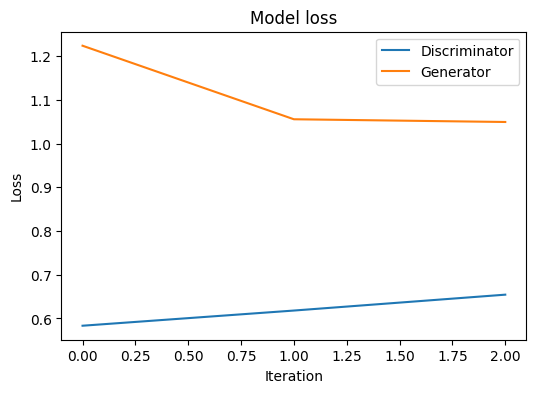

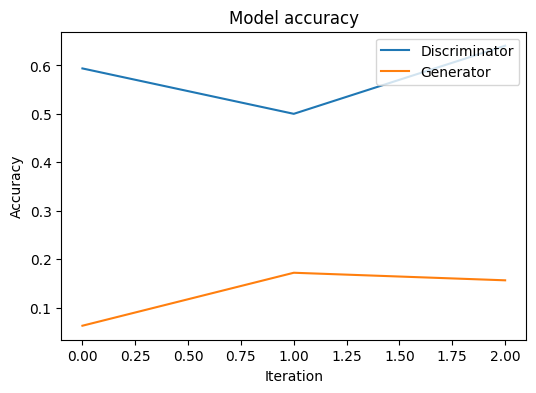

2/2 [==============================] - 0s 24ms/step
>2812, dr[0.597,0.562], df[0.561,0.734], g[1.175,0.125]
2/2 [==============================] - 0s 20ms/step
>2813, dr[0.685,0.516], df[0.471,0.891], g[1.060,0.141]
2/2 [==============================] - 0s 16ms/step
>2814, dr[0.596,0.750], df[0.496,0.828], g[1.183,0.062]
2/2 [==============================] - 0s 15ms/step
>2815, dr[0.644,0.547], df[0.618,0.672], g[1.004,0.203]
2/2 [==============================] - 0s 26ms/step
>2816, dr[0.499,0.719], df[0.613,0.703], g[1.090,0.125]
2/2 [==============================] - 0s 18ms/step
>2817, dr[0.577,0.625], df[0.633,0.734], g[1.086,0.109]
2/2 [==============================] - 0s 15ms/step
>2818, dr[0.728,0.469], df[0.577,0.766], g[1.070,0.141]
2/2 [==============================] - 0s 18ms/step
>2819, dr[0.716,0.531], df[0.650,0.719], g[1.074,0.172]
2/2 [==============================] - 0s 18ms/step
>2820, dr[0.549,0.641], df[0.517,0.828], g[1.005,0.234]
2/2 [=======================

>Saved: model_3748.h5


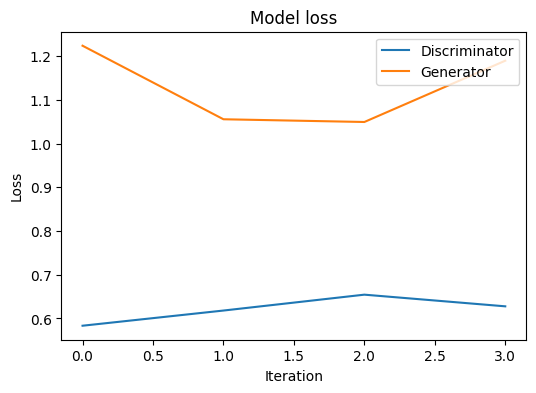

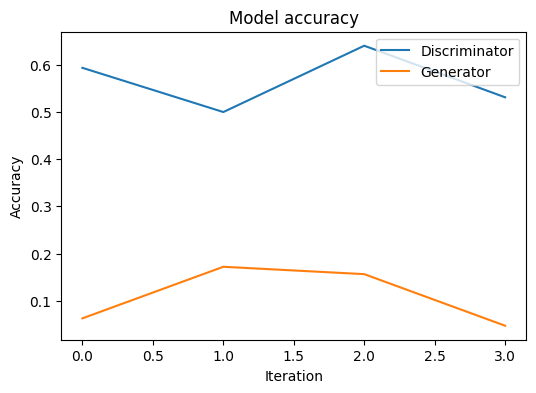

2/2 [==============================] - 0s 13ms/step
>3749, dr[0.631,0.516], df[0.503,0.844], g[1.155,0.109]
2/2 [==============================] - 0s 18ms/step
>3750, dr[0.685,0.500], df[0.603,0.766], g[1.084,0.125]
2/2 [==============================] - 0s 16ms/step
>3751, dr[0.647,0.594], df[0.566,0.812], g[1.011,0.156]
2/2 [==============================] - 0s 18ms/step
>3752, dr[0.579,0.609], df[0.588,0.781], g[1.052,0.141]
2/2 [==============================] - 0s 18ms/step
>3753, dr[0.674,0.531], df[0.543,0.844], g[1.042,0.188]
2/2 [==============================] - 0s 28ms/step
>3754, dr[0.673,0.469], df[0.527,0.844], g[1.037,0.125]
2/2 [==============================] - 0s 18ms/step
>3755, dr[0.574,0.656], df[0.635,0.688], g[1.018,0.156]
2/2 [==============================] - 0s 15ms/step
>3756, dr[0.579,0.625], df[0.621,0.781], g[0.981,0.172]
2/2 [==============================] - 0s 20ms/step
>3757, dr[0.653,0.547], df[0.589,0.750], g[1.077,0.141]
2/2 [=======================

>Saved: model_4685.h5


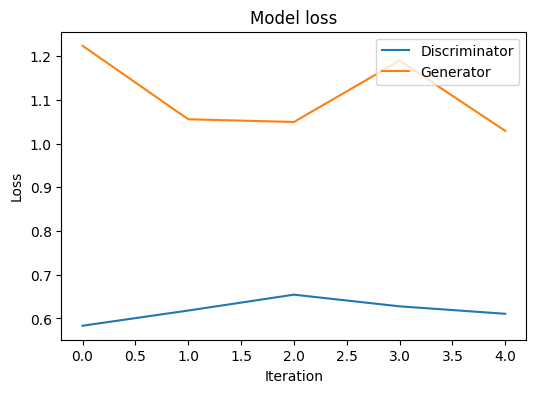

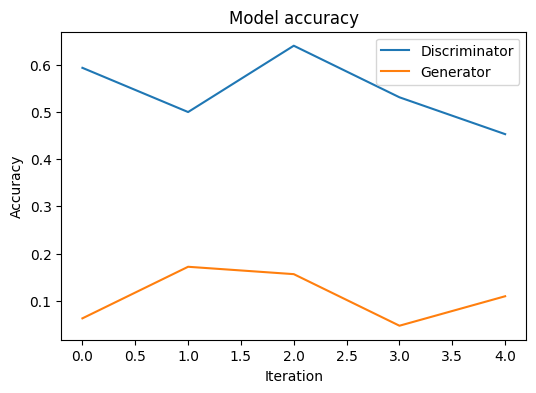

2/2 [==============================] - 0s 16ms/step
>4686, dr[0.599,0.547], df[0.718,0.641], g[0.978,0.203]
2/2 [==============================] - 0s 15ms/step
>4687, dr[0.620,0.578], df[0.603,0.734], g[1.047,0.172]
2/2 [==============================] - 0s 14ms/step
>4688, dr[0.695,0.438], df[0.613,0.734], g[1.028,0.156]
2/2 [==============================] - 0s 12ms/step
>4689, dr[0.668,0.562], df[0.508,0.844], g[1.045,0.172]
2/2 [==============================] - 0s 15ms/step
>4690, dr[0.610,0.609], df[0.616,0.766], g[0.951,0.203]
2/2 [==============================] - 0s 14ms/step
>4691, dr[0.691,0.484], df[0.708,0.719], g[0.918,0.297]
2/2 [==============================] - 0s 16ms/step
>4692, dr[0.657,0.531], df[0.669,0.609], g[1.043,0.188]
2/2 [==============================] - 0s 14ms/step
>4693, dr[0.598,0.594], df[0.624,0.703], g[0.963,0.203]
2/2 [==============================] - 0s 18ms/step
>4694, dr[0.608,0.625], df[0.610,0.656], g[1.051,0.234]
2/2 [=======================

>Saved: model_5622.h5


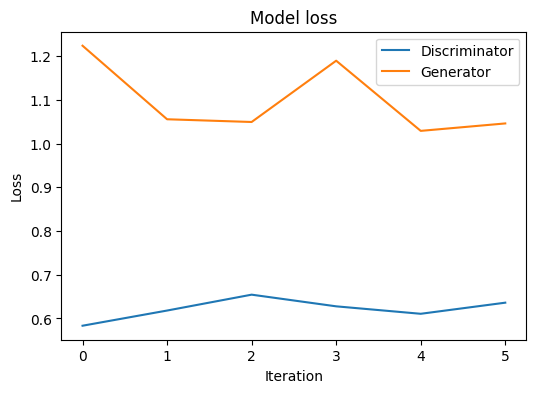

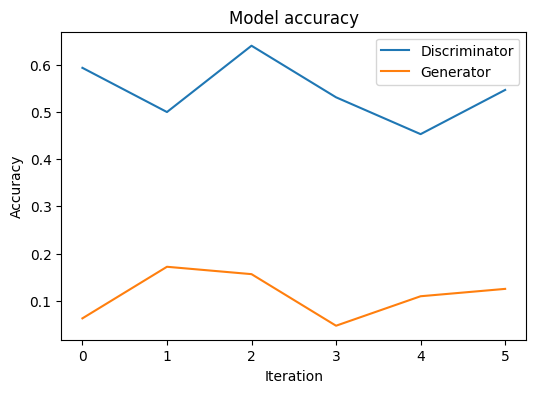

2/2 [==============================] - 0s 11ms/step
>5623, dr[0.636,0.562], df[0.551,0.812], g[0.999,0.188]
2/2 [==============================] - 0s 9ms/step
>5624, dr[0.676,0.562], df[0.582,0.750], g[1.057,0.188]
2/2 [==============================] - 0s 23ms/step
>5625, dr[0.441,0.812], df[0.680,0.656], g[0.968,0.250]
2/2 [==============================] - 0s 12ms/step
>5626, dr[0.579,0.656], df[0.688,0.688], g[1.008,0.172]
2/2 [==============================] - 0s 14ms/step
>5627, dr[0.659,0.594], df[0.596,0.750], g[1.112,0.094]
2/2 [==============================] - 0s 14ms/step
>5628, dr[0.663,0.531], df[0.541,0.781], g[1.039,0.156]
2/2 [==============================] - 0s 14ms/step
>5629, dr[0.645,0.609], df[0.575,0.797], g[1.031,0.188]
2/2 [==============================] - 0s 17ms/step
>5630, dr[0.608,0.625], df[0.642,0.609], g[1.065,0.141]
2/2 [==============================] - 0s 19ms/step
>5631, dr[0.569,0.703], df[0.609,0.766], g[0.993,0.234]
2/2 [========================

>Saved: model_6559.h5


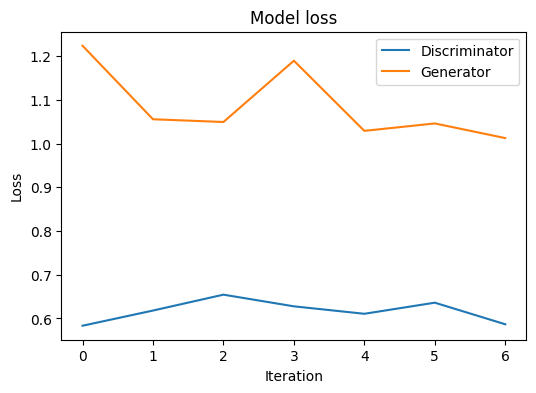

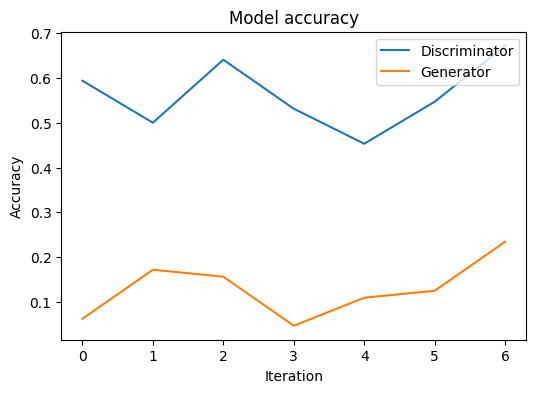

2/2 [==============================] - 0s 12ms/step
>6560, dr[0.572,0.641], df[0.563,0.781], g[1.012,0.188]
2/2 [==============================] - 0s 11ms/step
>6561, dr[0.643,0.578], df[0.588,0.719], g[1.074,0.156]
2/2 [==============================] - 0s 13ms/step
>6562, dr[0.703,0.484], df[0.647,0.703], g[1.046,0.156]
2/2 [==============================] - 0s 17ms/step
>6563, dr[0.638,0.578], df[0.580,0.734], g[1.098,0.125]
2/2 [==============================] - 0s 10ms/step
>6564, dr[0.676,0.469], df[0.573,0.781], g[0.929,0.297]
2/2 [==============================] - 0s 12ms/step
>6565, dr[0.722,0.469], df[0.686,0.703], g[0.970,0.266]
2/2 [==============================] - 0s 11ms/step
>6566, dr[0.782,0.484], df[0.626,0.672], g[1.082,0.094]
2/2 [==============================] - 0s 14ms/step
>6567, dr[0.588,0.656], df[0.689,0.750], g[1.049,0.172]
2/2 [==============================] - 0s 15ms/step
>6568, dr[0.628,0.625], df[0.565,0.781], g[1.003,0.234]
2/2 [=======================

>Saved: model_7496.h5


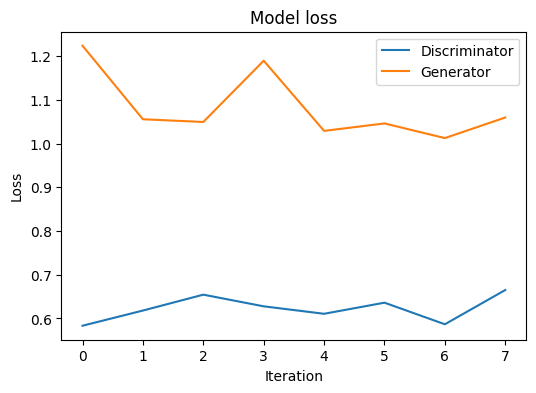

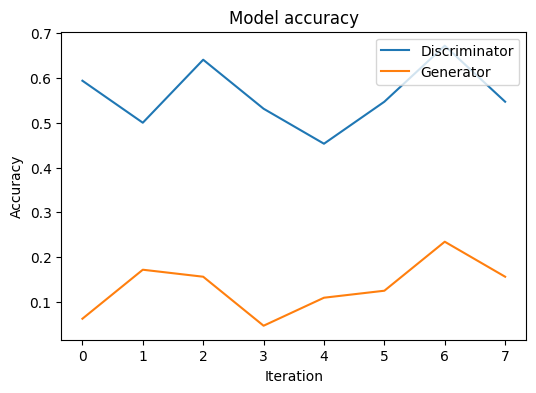

2/2 [==============================] - 0s 10ms/step
>7497, dr[0.571,0.641], df[0.585,0.719], g[0.990,0.188]
2/2 [==============================] - 0s 12ms/step
>7498, dr[0.665,0.516], df[0.520,0.859], g[0.967,0.234]
2/2 [==============================] - 0s 11ms/step
>7499, dr[0.647,0.594], df[0.693,0.656], g[1.080,0.156]
2/2 [==============================] - 0s 12ms/step
>7500, dr[0.630,0.562], df[0.569,0.750], g[1.009,0.188]
2/2 [==============================] - 0s 12ms/step
>7501, dr[0.685,0.500], df[0.555,0.781], g[1.044,0.125]
2/2 [==============================] - 0s 19ms/step
>7502, dr[0.572,0.672], df[0.658,0.625], g[1.042,0.203]
2/2 [==============================] - 0s 19ms/step
>7503, dr[0.535,0.641], df[0.530,0.797], g[1.085,0.125]
2/2 [==============================] - 0s 12ms/step
>7504, dr[0.639,0.547], df[0.522,0.812], g[1.169,0.109]
2/2 [==============================] - 0s 20ms/step
>7505, dr[0.675,0.578], df[0.619,0.750], g[1.045,0.203]
2/2 [=======================

>Saved: model_8433.h5


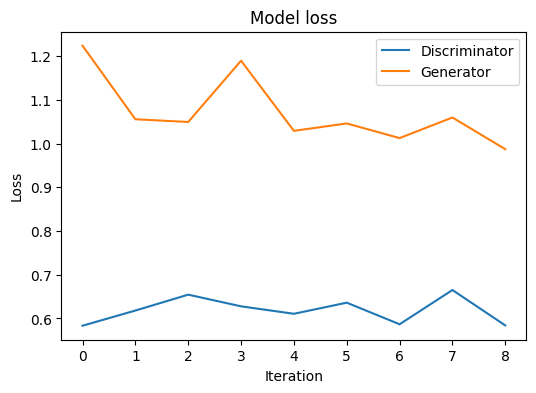

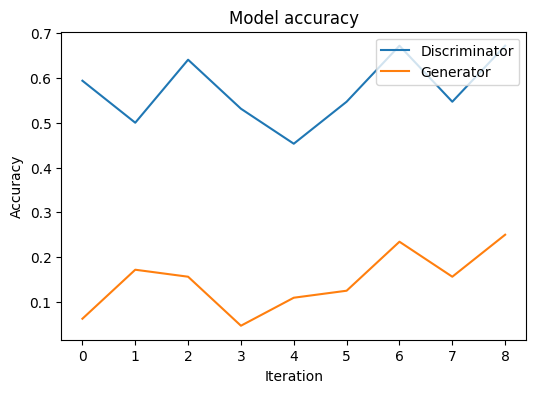

2/2 [==============================] - 0s 12ms/step
>8434, dr[0.557,0.625], df[0.719,0.594], g[1.016,0.250]
2/2 [==============================] - 0s 18ms/step
>8435, dr[0.553,0.656], df[0.583,0.750], g[1.087,0.109]
2/2 [==============================] - 0s 10ms/step
>8436, dr[0.533,0.594], df[0.522,0.859], g[1.096,0.094]
2/2 [==============================] - 0s 16ms/step
>8437, dr[0.590,0.656], df[0.613,0.750], g[1.062,0.141]
2/2 [==============================] - 0s 14ms/step
>8438, dr[0.663,0.562], df[0.661,0.719], g[1.059,0.141]
2/2 [==============================] - 0s 11ms/step
>8439, dr[0.604,0.578], df[0.533,0.750], g[1.114,0.125]
2/2 [==============================] - 0s 14ms/step
>8440, dr[0.543,0.688], df[0.618,0.672], g[1.066,0.125]
2/2 [==============================] - 0s 14ms/step
>8441, dr[0.596,0.609], df[0.542,0.844], g[1.150,0.078]
2/2 [==============================] - 0s 17ms/step
>8442, dr[0.559,0.688], df[0.589,0.797], g[1.055,0.125]
2/2 [=======================

>Saved: model_9370.h5


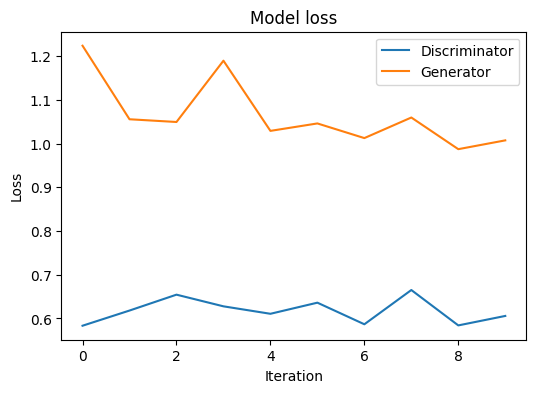

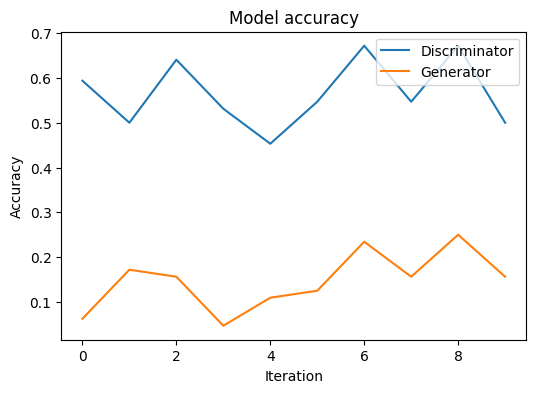

2/2 [==============================] - 0s 9ms/step
>9371, dr[0.580,0.641], df[0.589,0.703], g[1.096,0.109]
2/2 [==============================] - 0s 11ms/step
>9372, dr[0.635,0.562], df[0.552,0.719], g[1.117,0.203]
2/2 [==============================] - 0s 16ms/step
>9373, dr[0.616,0.609], df[0.581,0.766], g[1.048,0.156]
2/2 [==============================] - 0s 12ms/step
>9374, dr[0.545,0.625], df[0.506,0.781], g[1.027,0.203]
2/2 [==============================] - 0s 17ms/step
>9375, dr[0.514,0.656], df[0.647,0.688], g[1.035,0.156]
2/2 [==============================] - 0s 16ms/step
>9376, dr[0.631,0.578], df[0.618,0.781], g[1.030,0.219]
2/2 [==============================] - 0s 17ms/step
>9377, dr[0.530,0.688], df[0.596,0.766], g[1.018,0.141]
2/2 [==============================] - 0s 15ms/step
>9378, dr[0.630,0.578], df[0.592,0.750], g[1.046,0.172]
2/2 [==============================] - 0s 9ms/step
>9379, dr[0.662,0.547], df[0.591,0.812], g[1.127,0.109]
2/2 [=========================

>Saved: model_10307.h5


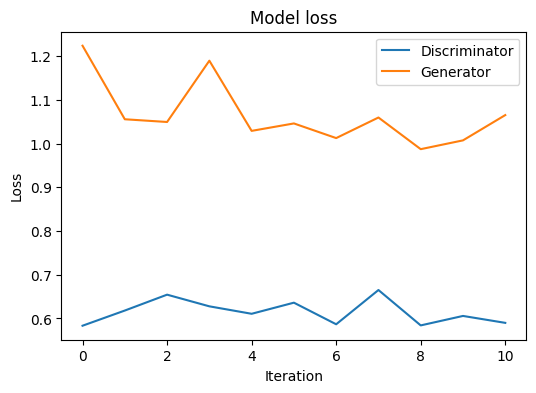

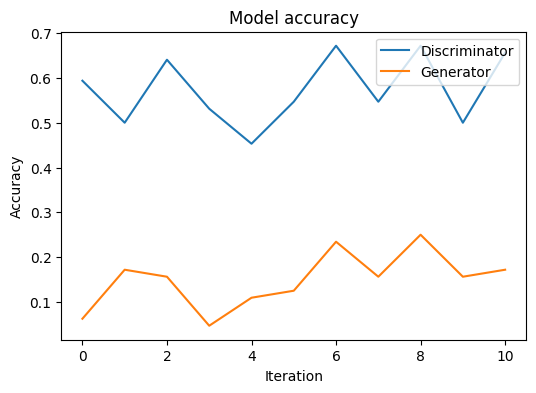

2/2 [==============================] - 0s 13ms/step
>10308, dr[0.594,0.594], df[0.613,0.812], g[1.055,0.125]
2/2 [==============================] - 0s 11ms/step
>10309, dr[0.507,0.688], df[0.597,0.719], g[1.021,0.188]
2/2 [==============================] - 0s 11ms/step
>10310, dr[0.643,0.547], df[0.508,0.859], g[0.995,0.234]
2/2 [==============================] - 0s 12ms/step
>10311, dr[0.654,0.609], df[0.546,0.750], g[1.016,0.188]
2/2 [==============================] - 0s 10ms/step
>10312, dr[0.580,0.609], df[0.698,0.594], g[0.922,0.391]
2/2 [==============================] - 0s 15ms/step
>10313, dr[0.594,0.672], df[0.597,0.734], g[1.075,0.125]
2/2 [==============================] - 0s 15ms/step
>10314, dr[0.720,0.516], df[0.649,0.703], g[1.035,0.188]
2/2 [==============================] - 0s 12ms/step
>10315, dr[0.594,0.641], df[0.560,0.766], g[0.990,0.156]
2/2 [==============================] - 0s 19ms/step
>10316, dr[0.642,0.531], df[0.714,0.625], g[0.965,0.172]
2/2 [==============

>Saved: model_11244.h5


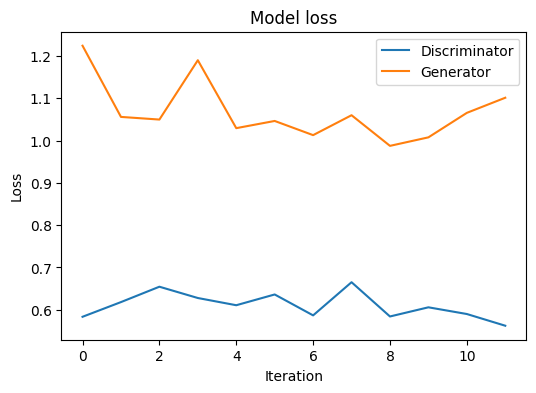

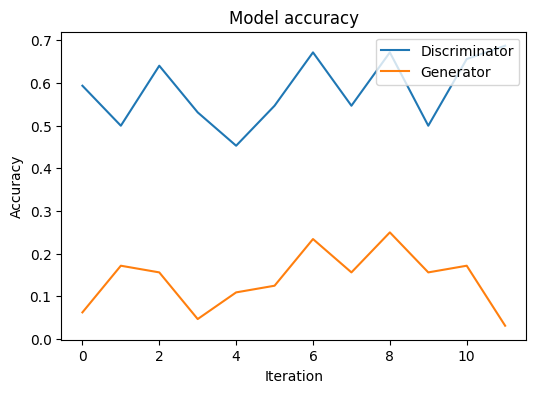

2/2 [==============================] - 0s 12ms/step
>11245, dr[0.559,0.625], df[0.573,0.688], g[1.029,0.094]
2/2 [==============================] - 0s 14ms/step
>11246, dr[0.618,0.547], df[0.551,0.797], g[1.024,0.156]
2/2 [==============================] - 0s 12ms/step
>11247, dr[0.593,0.594], df[0.714,0.719], g[1.060,0.188]
2/2 [==============================] - 0s 12ms/step
>11248, dr[0.600,0.625], df[0.642,0.734], g[1.002,0.203]
2/2 [==============================] - 0s 11ms/step
>11249, dr[0.530,0.672], df[0.623,0.703], g[1.008,0.203]
2/2 [==============================] - 0s 12ms/step
>11250, dr[0.588,0.594], df[0.613,0.656], g[1.060,0.141]
2/2 [==============================] - 0s 10ms/step
>11251, dr[0.609,0.609], df[0.525,0.750], g[1.011,0.125]
2/2 [==============================] - 0s 11ms/step
>11252, dr[0.635,0.562], df[0.637,0.734], g[1.012,0.125]
2/2 [==============================] - 0s 13ms/step
>11253, dr[0.678,0.547], df[0.590,0.656], g[1.012,0.141]
2/2 [==============

>Saved: model_12181.h5


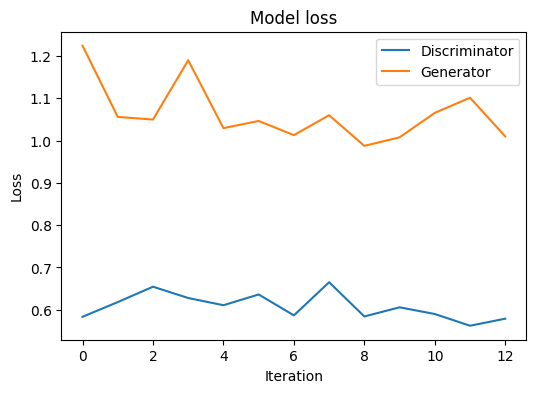

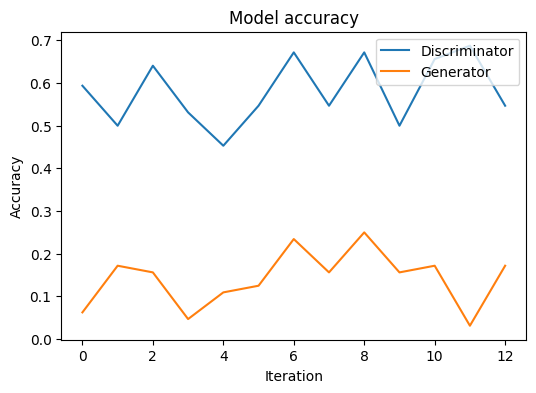

2/2 [==============================] - 0s 17ms/step
>12182, dr[0.555,0.703], df[0.658,0.656], g[0.984,0.141]
2/2 [==============================] - 0s 14ms/step
>12183, dr[0.621,0.594], df[0.596,0.750], g[1.107,0.078]
2/2 [==============================] - 0s 11ms/step
>12184, dr[0.605,0.609], df[0.603,0.781], g[1.025,0.125]
2/2 [==============================] - 0s 14ms/step
>12185, dr[0.636,0.594], df[0.542,0.797], g[1.043,0.156]
2/2 [==============================] - 0s 14ms/step
>12186, dr[0.550,0.672], df[0.590,0.734], g[0.989,0.188]
2/2 [==============================] - 0s 14ms/step
>12187, dr[0.623,0.547], df[0.619,0.688], g[1.009,0.156]
2/2 [==============================] - 0s 11ms/step
>12188, dr[0.500,0.656], df[0.576,0.781], g[1.005,0.188]
2/2 [==============================] - 0s 12ms/step
>12189, dr[0.705,0.531], df[0.605,0.703], g[1.074,0.109]
2/2 [==============================] - 0s 11ms/step
>12190, dr[0.554,0.641], df[0.626,0.719], g[0.983,0.141]
2/2 [==============

>Saved: model_13118.h5


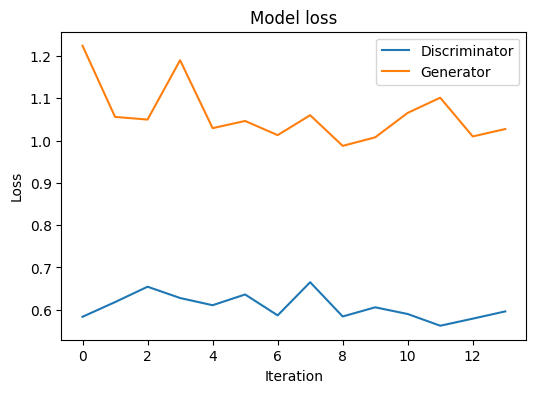

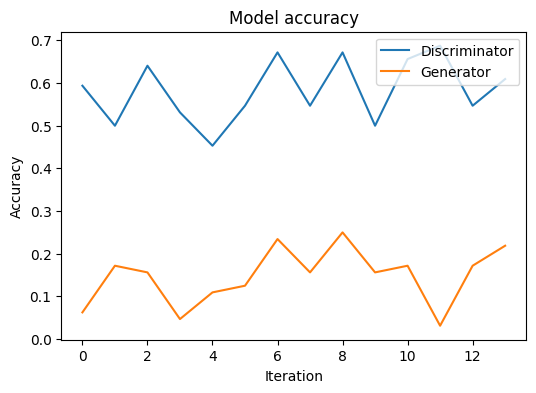

2/2 [==============================] - 0s 11ms/step
>13119, dr[0.616,0.578], df[0.603,0.766], g[1.102,0.188]
2/2 [==============================] - 0s 10ms/step
>13120, dr[0.611,0.609], df[0.581,0.766], g[1.079,0.109]
2/2 [==============================] - 0s 12ms/step
>13121, dr[0.525,0.734], df[0.564,0.828], g[0.975,0.266]
2/2 [==============================] - 0s 10ms/step
>13122, dr[0.567,0.672], df[0.653,0.703], g[1.110,0.156]
2/2 [==============================] - 0s 13ms/step
>13123, dr[0.666,0.484], df[0.473,0.844], g[1.076,0.094]
2/2 [==============================] - 0s 13ms/step
>13124, dr[0.559,0.625], df[0.578,0.766], g[1.018,0.172]
2/2 [==============================] - 0s 14ms/step
>13125, dr[0.629,0.578], df[0.595,0.750], g[0.983,0.250]
2/2 [==============================] - 0s 12ms/step
>13126, dr[0.522,0.672], df[0.541,0.828], g[1.012,0.156]
2/2 [==============================] - 0s 14ms/step
>13127, dr[0.589,0.625], df[0.601,0.766], g[1.032,0.219]
2/2 [==============

>Saved: model_14055.h5


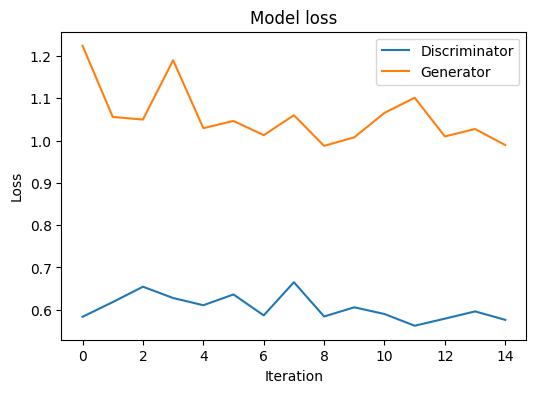

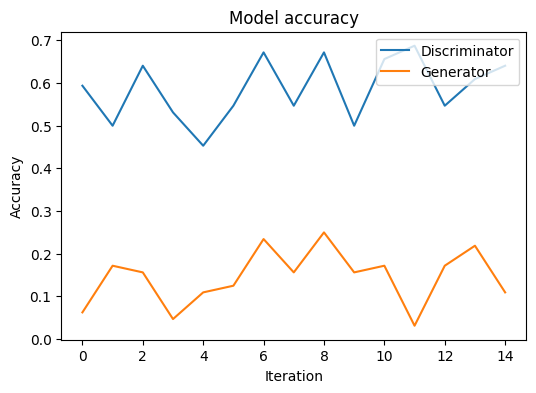

2/2 [==============================] - 0s 12ms/step
>14056, dr[0.653,0.562], df[0.630,0.719], g[1.028,0.172]
2/2 [==============================] - 0s 14ms/step
>14057, dr[0.632,0.516], df[0.663,0.688], g[1.012,0.172]
2/2 [==============================] - 0s 12ms/step
>14058, dr[0.591,0.609], df[0.651,0.734], g[1.060,0.156]
2/2 [==============================] - 0s 11ms/step
>14059, dr[0.677,0.500], df[0.523,0.859], g[1.058,0.203]
2/2 [==============================] - 0s 14ms/step
>14060, dr[0.485,0.781], df[0.574,0.766], g[0.967,0.203]
2/2 [==============================] - 0s 14ms/step
>14061, dr[0.592,0.703], df[0.695,0.641], g[1.077,0.109]
2/2 [==============================] - 0s 10ms/step
>14062, dr[0.619,0.609], df[0.566,0.750], g[1.071,0.109]
2/2 [==============================] - 0s 17ms/step
>14063, dr[0.670,0.562], df[0.595,0.719], g[1.060,0.125]
2/2 [==============================] - 0s 9ms/step
>14064, dr[0.699,0.594], df[0.524,0.828], g[1.083,0.109]
2/2 [===============

>Saved: model_14992.h5


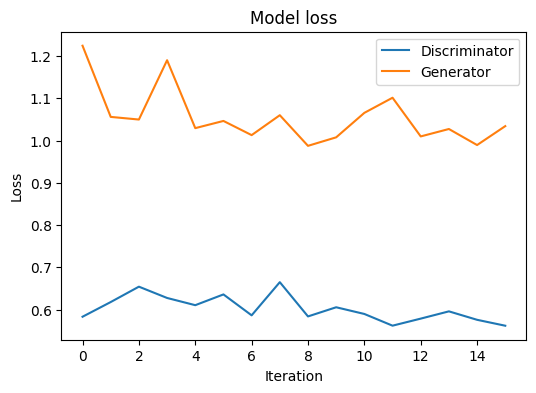

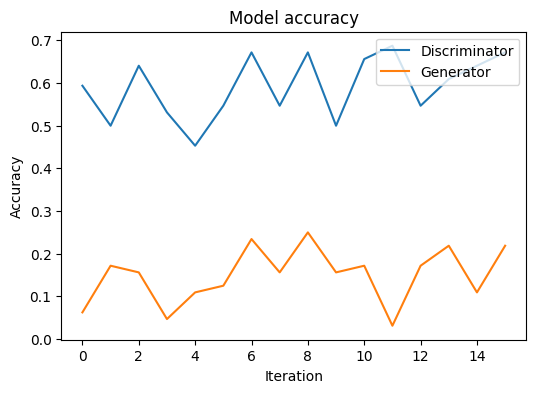

2/2 [==============================] - 0s 16ms/step
>14993, dr[0.547,0.688], df[0.566,0.750], g[1.079,0.125]
2/2 [==============================] - 0s 13ms/step
>14994, dr[0.642,0.609], df[0.633,0.734], g[1.036,0.234]
2/2 [==============================] - 0s 16ms/step
>14995, dr[0.672,0.547], df[0.685,0.719], g[1.079,0.172]
2/2 [==============================] - 0s 15ms/step
>14996, dr[0.565,0.656], df[0.549,0.734], g[1.118,0.172]
2/2 [==============================] - 0s 10ms/step
>14997, dr[0.523,0.688], df[0.607,0.766], g[1.235,0.141]
2/2 [==============================] - 0s 10ms/step
>14998, dr[0.612,0.547], df[0.525,0.828], g[1.124,0.156]
2/2 [==============================] - 0s 11ms/step
>14999, dr[0.769,0.469], df[0.631,0.719], g[1.053,0.156]
2/2 [==============================] - 0s 9ms/step
>15000, dr[0.652,0.594], df[0.669,0.672], g[0.998,0.203]
2/2 [==============================] - 0s 10ms/step
>15001, dr[0.661,0.594], df[0.608,0.734], g[1.103,0.141]
2/2 [===============

>Saved: model_15929.h5


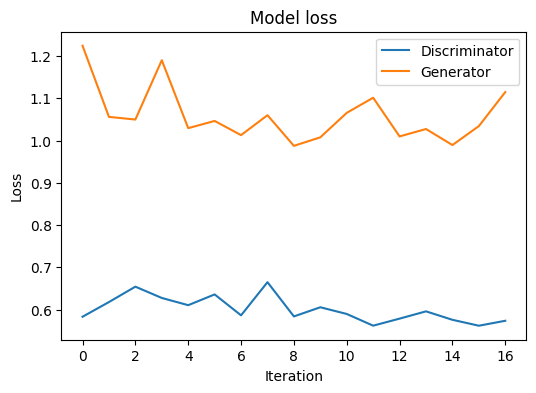

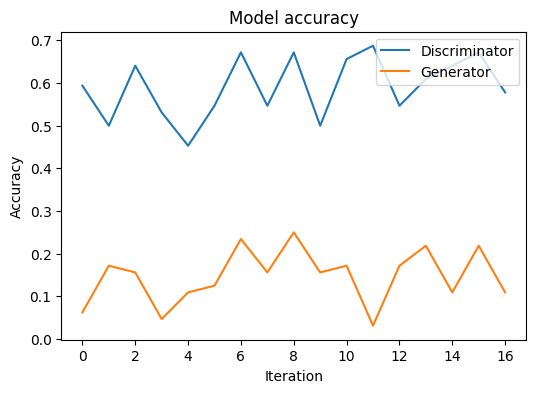

2/2 [==============================] - 0s 14ms/step
>15930, dr[0.504,0.719], df[0.517,0.859], g[1.068,0.172]
2/2 [==============================] - 0s 11ms/step
>15931, dr[0.581,0.641], df[0.563,0.766], g[1.096,0.125]
2/2 [==============================] - 0s 10ms/step
>15932, dr[0.601,0.672], df[0.651,0.641], g[1.026,0.172]
2/2 [==============================] - 0s 10ms/step
>15933, dr[0.652,0.516], df[0.591,0.781], g[1.166,0.156]
2/2 [==============================] - 0s 17ms/step
>15934, dr[0.534,0.672], df[0.525,0.797], g[1.093,0.156]
2/2 [==============================] - 0s 14ms/step
>15935, dr[0.567,0.672], df[0.635,0.750], g[1.095,0.078]
2/2 [==============================] - 0s 13ms/step
>15936, dr[0.617,0.656], df[0.556,0.781], g[0.977,0.172]
2/2 [==============================] - 0s 12ms/step
>15937, dr[0.599,0.609], df[0.722,0.719], g[1.112,0.141]
2/2 [==============================] - 0s 10ms/step
>15938, dr[0.560,0.625], df[0.592,0.812], g[1.025,0.188]
2/2 [==============

>Saved: model_16866.h5


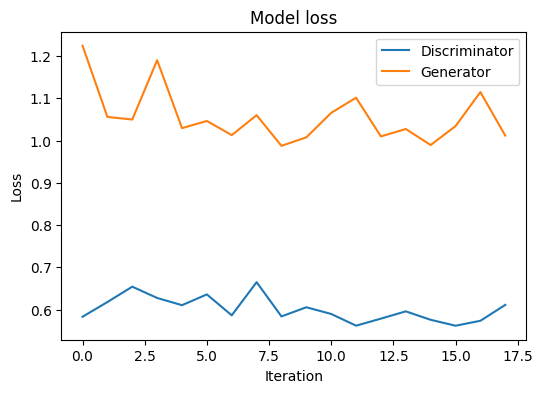

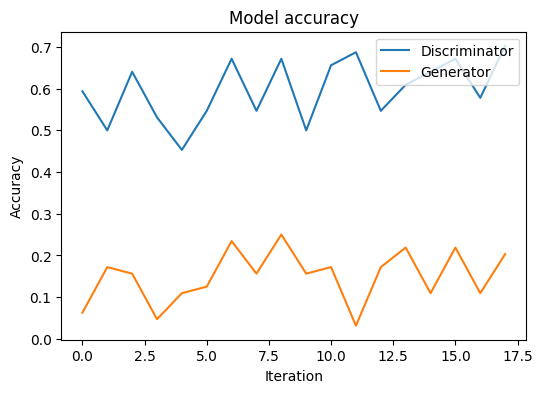

2/2 [==============================] - 0s 15ms/step
>16867, dr[0.509,0.703], df[0.624,0.625], g[1.185,0.172]
2/2 [==============================] - 0s 21ms/step
>16868, dr[0.601,0.672], df[0.466,0.844], g[1.103,0.109]
2/2 [==============================] - 0s 16ms/step
>16869, dr[0.639,0.562], df[0.609,0.812], g[1.115,0.125]
2/2 [==============================] - 0s 11ms/step
>16870, dr[0.492,0.703], df[0.667,0.641], g[1.035,0.234]
2/2 [==============================] - 0s 13ms/step
>16871, dr[0.577,0.672], df[0.507,0.797], g[1.106,0.156]
2/2 [==============================] - 0s 13ms/step
>16872, dr[0.519,0.688], df[0.722,0.562], g[1.069,0.156]
2/2 [==============================] - 0s 16ms/step
>16873, dr[0.626,0.562], df[0.626,0.641], g[1.099,0.172]
2/2 [==============================] - 0s 14ms/step
>16874, dr[0.698,0.531], df[0.498,0.828], g[1.111,0.172]
2/2 [==============================] - 0s 10ms/step
>16875, dr[0.668,0.516], df[0.580,0.719], g[1.018,0.188]
2/2 [==============

>Saved: model_17803.h5


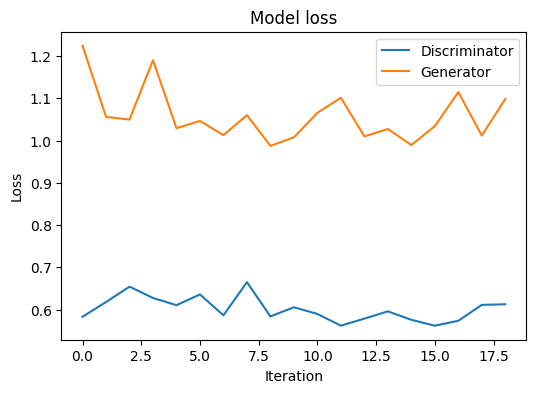

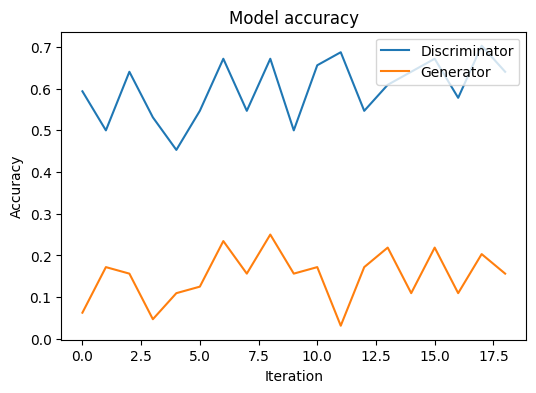

2/2 [==============================] - 0s 11ms/step
>17804, dr[0.520,0.734], df[0.498,0.875], g[1.075,0.188]
2/2 [==============================] - 0s 12ms/step
>17805, dr[0.517,0.609], df[0.631,0.688], g[1.080,0.172]
2/2 [==============================] - 0s 14ms/step
>17806, dr[0.683,0.484], df[0.510,0.766], g[1.106,0.141]
2/2 [==============================] - 0s 12ms/step
>17807, dr[0.617,0.609], df[0.654,0.656], g[1.050,0.188]
2/2 [==============================] - 0s 13ms/step
>17808, dr[0.609,0.578], df[0.555,0.703], g[1.073,0.141]
2/2 [==============================] - 0s 16ms/step
>17809, dr[0.570,0.609], df[0.532,0.812], g[1.038,0.141]
2/2 [==============================] - 0s 11ms/step
>17810, dr[0.610,0.594], df[0.558,0.781], g[1.058,0.203]
2/2 [==============================] - 0s 15ms/step
>17811, dr[0.594,0.625], df[0.622,0.797], g[1.001,0.203]
2/2 [==============================] - 0s 11ms/step
>17812, dr[0.600,0.609], df[0.527,0.844], g[1.078,0.234]
2/2 [==============

>Saved: model_18740.h5


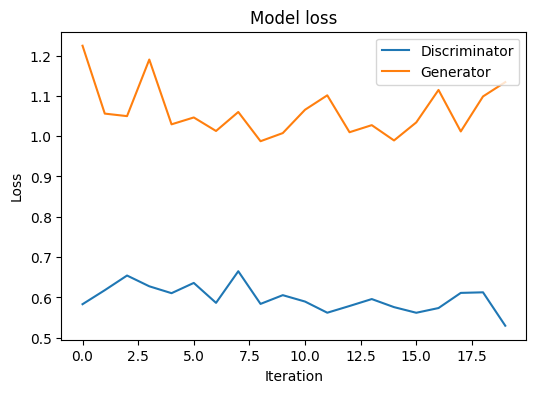

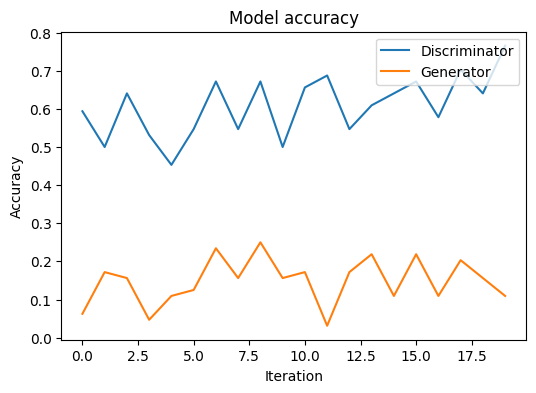

In [31]:
latent_dim = 5
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

In [ ]:
# load one of the saved models and try and generate fake samples
model = load_model('model_16866.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_80 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_39 (Dropout)        (None, 1024)              0         
                                                                 
 dense_81 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 512)               0  

>1, dr[0.408,0.969], df[1.743,0.000], g[0.363,1.000]
2/2 [==============================] - 0s 11ms/step
>2, dr[0.311,1.000], df[1.257,0.000], g[0.494,0.922]
2/2 [==============================] - 0s 10ms/step
>3, dr[0.476,0.891], df[1.025,0.109], g[0.642,0.656]
2/2 [==============================] - 0s 10ms/step
>4, dr[0.624,0.734], df[0.877,0.250], g[0.648,0.609]
2/2 [==============================] - 0s 11ms/step
>5, dr[0.681,0.656], df[0.850,0.234], g[0.743,0.391]
2/2 [==============================] - 0s 10ms/step
>6, dr[0.680,0.578], df[0.817,0.297], g[0.797,0.297]
2/2 [==============================] - 0s 11ms/step
>7, dr[0.719,0.422], df[0.747,0.328], g[0.699,0.547]
2/2 [==============================] - 0s 10ms/step
>8, dr[0.734,0.422], df[0.783,0.312], g[0.717,0.500]
2/2 [==============================] - 0s 12ms/step
>9, dr[0.727,0.453], df[0.772,0.297], g[0.708,0.484]
2/2 [==============================] - 0s 10ms/step
>10, dr[0.714,0.453], df[0.759,0.281], g[0.704,0.516]
2

>Saved: model_0937.h5


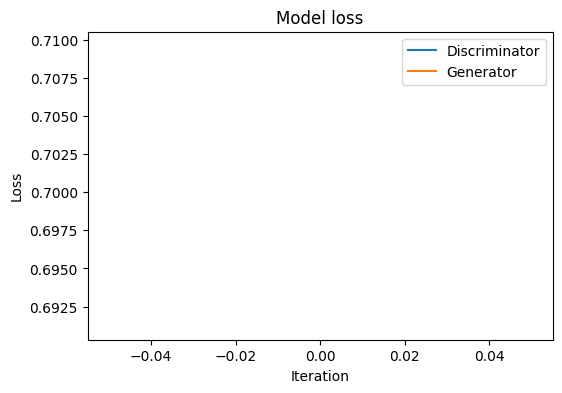

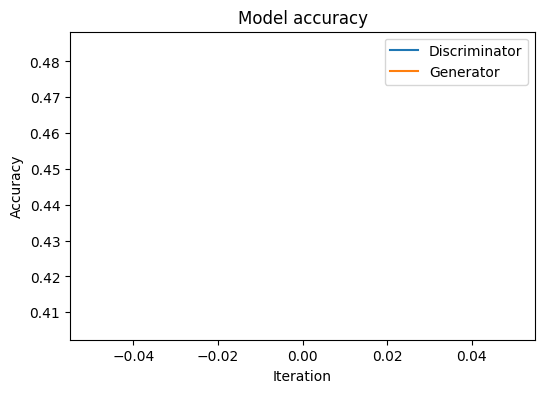

2/2 [==============================] - 0s 13ms/step
>938, dr[0.696,0.391], df[0.682,0.609], g[0.690,0.500]
2/2 [==============================] - 0s 14ms/step
>939, dr[0.693,0.438], df[0.710,0.391], g[0.698,0.406]
2/2 [==============================] - 0s 12ms/step
>940, dr[0.679,0.578], df[0.699,0.469], g[0.690,0.406]
2/2 [==============================] - 0s 15ms/step
>941, dr[0.688,0.469], df[0.709,0.469], g[0.698,0.422]
2/2 [==============================] - 0s 12ms/step
>942, dr[0.698,0.391], df[0.704,0.500], g[0.693,0.375]
2/2 [==============================] - 0s 12ms/step
>943, dr[0.701,0.453], df[0.708,0.406], g[0.702,0.375]
2/2 [==============================] - 0s 12ms/step
>944, dr[0.695,0.500], df[0.680,0.641], g[0.718,0.297]
2/2 [==============================] - 0s 19ms/step
>945, dr[0.698,0.359], df[0.682,0.672], g[0.698,0.469]
2/2 [==============================] - 0s 8ms/step
>946, dr[0.708,0.297], df[0.699,0.469], g[0.703,0.344]
2/2 [==============================] -

>Saved: model_1874.h5


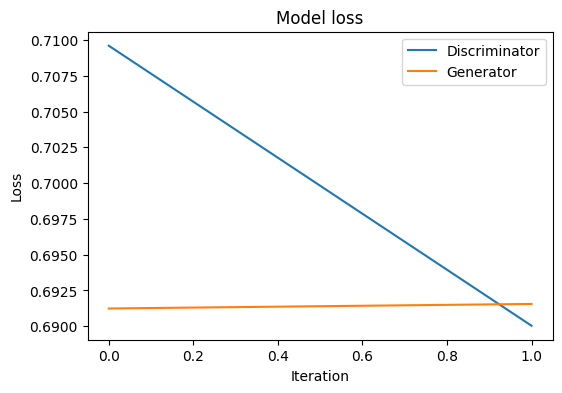

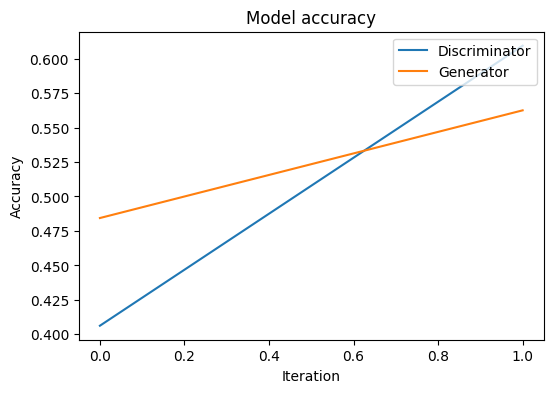

2/2 [==============================] - 0s 12ms/step
>1875, dr[0.695,0.422], df[0.691,0.547], g[0.695,0.484]
2/2 [==============================] - 0s 16ms/step
>1876, dr[0.699,0.391], df[0.683,0.672], g[0.697,0.422]
2/2 [==============================] - 0s 8ms/step
>1877, dr[0.699,0.359], df[0.697,0.516], g[0.693,0.406]
2/2 [==============================] - 0s 12ms/step
>1878, dr[0.702,0.359], df[0.693,0.562], g[0.698,0.438]
2/2 [==============================] - 0s 15ms/step
>1879, dr[0.698,0.438], df[0.689,0.516], g[0.706,0.312]
2/2 [==============================] - 0s 14ms/step
>1880, dr[0.705,0.312], df[0.681,0.750], g[0.694,0.422]
2/2 [==============================] - 0s 13ms/step
>1881, dr[0.700,0.375], df[0.690,0.656], g[0.703,0.297]
2/2 [==============================] - 0s 16ms/step
>1882, dr[0.701,0.422], df[0.688,0.594], g[0.697,0.453]
2/2 [==============================] - 0s 12ms/step
>1883, dr[0.704,0.328], df[0.684,0.578], g[0.713,0.297]
2/2 [========================

>Saved: model_2811.h5


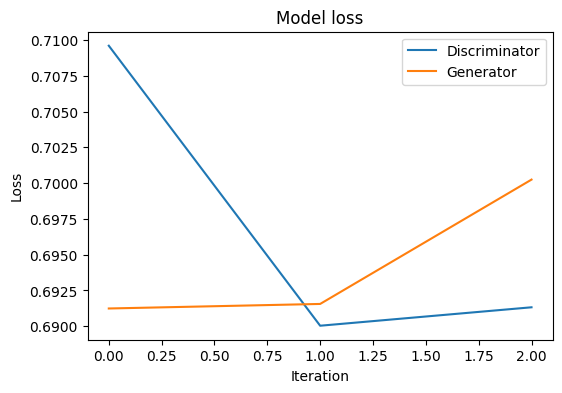

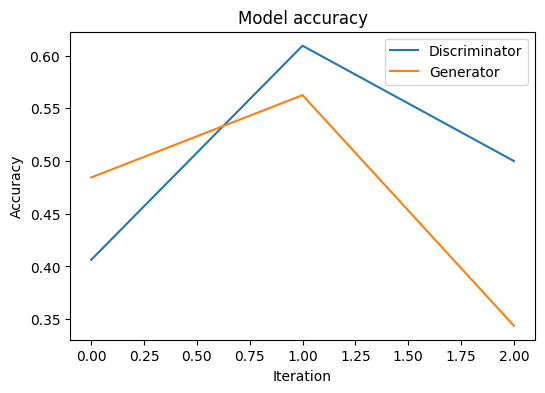

2/2 [==============================] - 0s 16ms/step
>2812, dr[0.693,0.594], df[0.699,0.516], g[0.700,0.328]
2/2 [==============================] - 0s 13ms/step
>2813, dr[0.695,0.375], df[0.695,0.469], g[0.698,0.422]
2/2 [==============================] - 0s 15ms/step
>2814, dr[0.692,0.516], df[0.698,0.469], g[0.693,0.453]
2/2 [==============================] - 0s 13ms/step
>2815, dr[0.702,0.438], df[0.694,0.500], g[0.691,0.516]
2/2 [==============================] - 0s 12ms/step
>2816, dr[0.697,0.406], df[0.693,0.578], g[0.689,0.578]
2/2 [==============================] - 0s 11ms/step
>2817, dr[0.697,0.359], df[0.694,0.547], g[0.697,0.359]
2/2 [==============================] - 0s 11ms/step
>2818, dr[0.695,0.516], df[0.694,0.453], g[0.700,0.375]
2/2 [==============================] - 0s 11ms/step
>2819, dr[0.694,0.500], df[0.698,0.422], g[0.693,0.516]
2/2 [==============================] - 0s 10ms/step
>2820, dr[0.692,0.594], df[0.692,0.625], g[0.690,0.531]
2/2 [=======================

>Saved: model_3748.h5


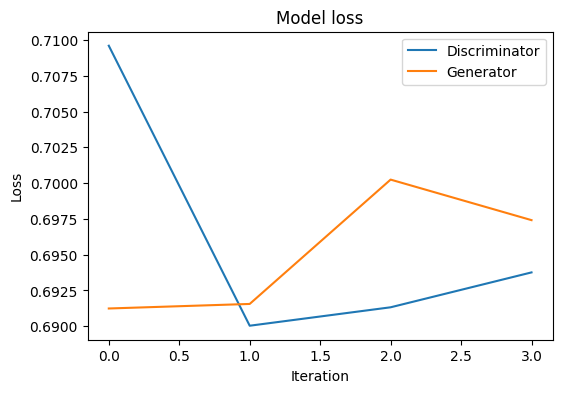

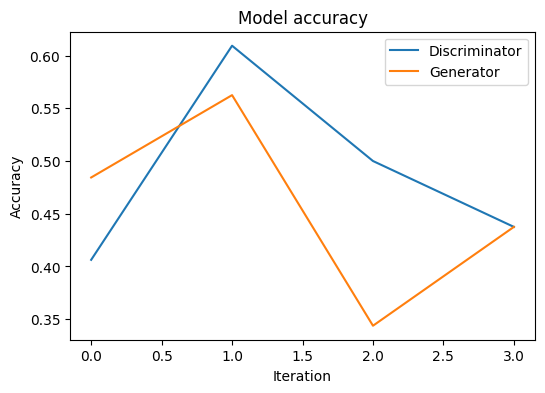

2/2 [==============================] - 0s 13ms/step
>3749, dr[0.694,0.469], df[0.694,0.484], g[0.695,0.406]
2/2 [==============================] - 0s 11ms/step
>3750, dr[0.698,0.438], df[0.695,0.469], g[0.692,0.438]
2/2 [==============================] - 0s 15ms/step
>3751, dr[0.689,0.547], df[0.696,0.422], g[0.700,0.391]
2/2 [==============================] - 0s 17ms/step
>3752, dr[0.690,0.547], df[0.692,0.531], g[0.694,0.516]
2/2 [==============================] - 0s 12ms/step
>3753, dr[0.699,0.328], df[0.695,0.484], g[0.695,0.438]
2/2 [==============================] - 0s 11ms/step
>3754, dr[0.689,0.672], df[0.694,0.453], g[0.694,0.516]
2/2 [==============================] - 0s 12ms/step
>3755, dr[0.693,0.516], df[0.694,0.438], g[0.696,0.438]
2/2 [==============================] - 0s 17ms/step
>3756, dr[0.692,0.453], df[0.691,0.609], g[0.694,0.500]
2/2 [==============================] - 0s 12ms/step
>3757, dr[0.693,0.484], df[0.694,0.562], g[0.695,0.438]
2/2 [=======================

>Saved: model_4685.h5


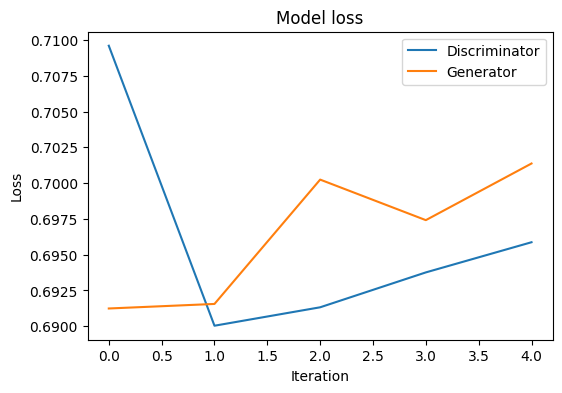

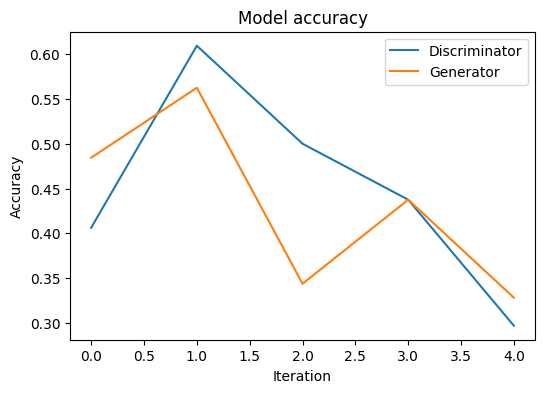

2/2 [==============================] - 0s 12ms/step
>4686, dr[0.700,0.344], df[0.690,0.562], g[0.700,0.266]
2/2 [==============================] - 0s 11ms/step
>4687, dr[0.700,0.312], df[0.689,0.734], g[0.701,0.344]
2/2 [==============================] - 0s 13ms/step
>4688, dr[0.699,0.391], df[0.684,0.781], g[0.702,0.297]
2/2 [==============================] - 0s 14ms/step
>4689, dr[0.701,0.281], df[0.685,0.656], g[0.702,0.328]
2/2 [==============================] - 0s 13ms/step
>4690, dr[0.699,0.328], df[0.690,0.609], g[0.706,0.156]
2/2 [==============================] - 0s 11ms/step
>4691, dr[0.703,0.250], df[0.685,0.656], g[0.702,0.234]
2/2 [==============================] - 0s 12ms/step
>4692, dr[0.698,0.375], df[0.686,0.672], g[0.702,0.328]
2/2 [==============================] - 0s 10ms/step
>4693, dr[0.701,0.266], df[0.687,0.641], g[0.700,0.344]
2/2 [==============================] - 0s 11ms/step
>4694, dr[0.703,0.328], df[0.688,0.594], g[0.703,0.250]
2/2 [=======================

>Saved: model_5622.h5


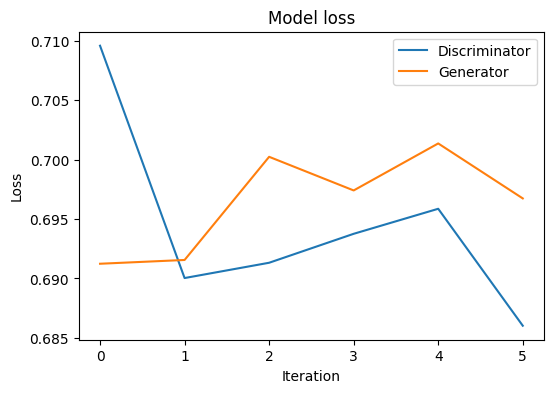

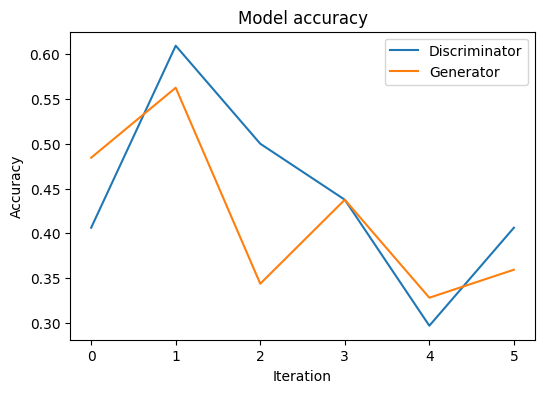

2/2 [==============================] - 0s 19ms/step
>5623, dr[0.697,0.422], df[0.675,0.734], g[0.702,0.391]
2/2 [==============================] - 0s 18ms/step
>5624, dr[0.686,0.406], df[0.720,0.609], g[0.707,0.297]
2/2 [==============================] - 0s 16ms/step
>5625, dr[0.688,0.453], df[0.684,0.625], g[0.700,0.406]
2/2 [==============================] - 0s 12ms/step
>5626, dr[0.679,0.500], df[0.718,0.500], g[0.685,0.500]
2/2 [==============================] - 0s 9ms/step
>5627, dr[0.660,0.594], df[0.719,0.422], g[0.693,0.469]
2/2 [==============================] - 0s 12ms/step
>5628, dr[0.672,0.562], df[0.716,0.406], g[0.687,0.484]
2/2 [==============================] - 0s 14ms/step
>5629, dr[0.669,0.578], df[0.702,0.516], g[0.698,0.594]
2/2 [==============================] - 0s 15ms/step
>5630, dr[0.662,0.578], df[0.733,0.375], g[0.716,0.297]
2/2 [==============================] - 0s 12ms/step
>5631, dr[0.684,0.594], df[0.711,0.453], g[0.726,0.359]
2/2 [========================

>Saved: model_6559.h5


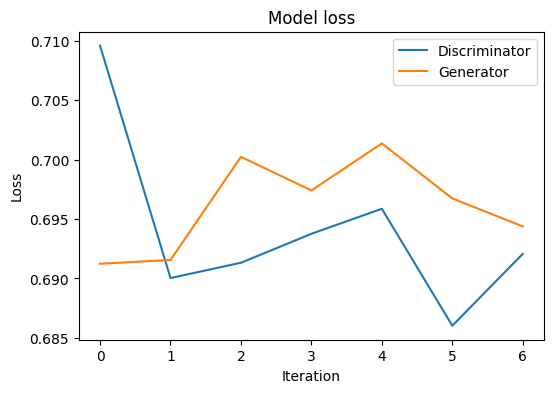

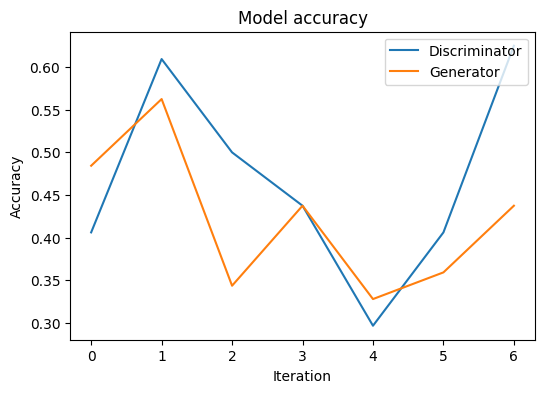

2/2 [==============================] - 0s 17ms/step
>6560, dr[0.696,0.484], df[0.686,0.578], g[0.702,0.422]
2/2 [==============================] - 0s 10ms/step
>6561, dr[0.699,0.469], df[0.706,0.422], g[0.702,0.438]
2/2 [==============================] - 0s 10ms/step
>6562, dr[0.703,0.469], df[0.686,0.609], g[0.703,0.484]
2/2 [==============================] - 0s 11ms/step
>6563, dr[0.699,0.500], df[0.693,0.500], g[0.700,0.328]
2/2 [==============================] - 0s 14ms/step
>6564, dr[0.697,0.562], df[0.699,0.469], g[0.697,0.422]
2/2 [==============================] - 0s 17ms/step
>6565, dr[0.687,0.594], df[0.707,0.469], g[0.684,0.594]
2/2 [==============================] - 0s 13ms/step
>6566, dr[0.689,0.547], df[0.704,0.422], g[0.697,0.453]
2/2 [==============================] - 0s 16ms/step
>6567, dr[0.685,0.609], df[0.704,0.406], g[0.695,0.375]
2/2 [==============================] - 0s 15ms/step
>6568, dr[0.686,0.594], df[0.699,0.406], g[0.690,0.469]
2/2 [=======================

>Saved: model_7496.h5


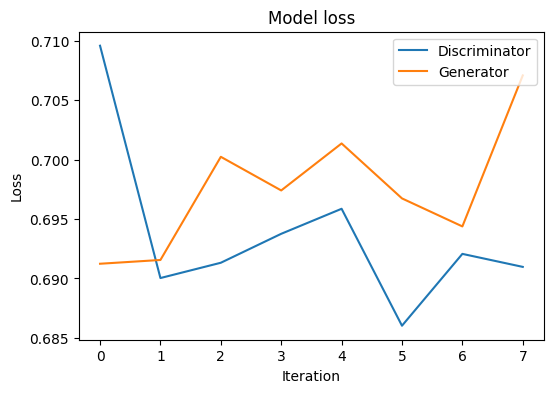

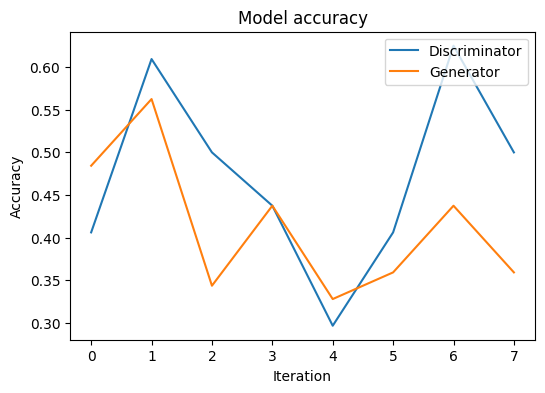

2/2 [==============================] - 0s 21ms/step
>7497, dr[0.696,0.375], df[0.691,0.625], g[0.703,0.344]
2/2 [==============================] - 0s 11ms/step
>7498, dr[0.700,0.406], df[0.692,0.531], g[0.705,0.250]
2/2 [==============================] - 0s 12ms/step
>7499, dr[0.700,0.406], df[0.684,0.625], g[0.714,0.188]
2/2 [==============================] - 0s 15ms/step
>7500, dr[0.707,0.312], df[0.681,0.656], g[0.708,0.234]
2/2 [==============================] - 0s 14ms/step
>7501, dr[0.703,0.312], df[0.685,0.609], g[0.708,0.250]
2/2 [==============================] - 0s 9ms/step
>7502, dr[0.702,0.391], df[0.684,0.672], g[0.711,0.188]
2/2 [==============================] - 0s 13ms/step
>7503, dr[0.702,0.391], df[0.688,0.562], g[0.705,0.281]
2/2 [==============================] - 0s 9ms/step
>7504, dr[0.693,0.500], df[0.687,0.547], g[0.699,0.328]
2/2 [==============================] - 0s 12ms/step
>7505, dr[0.692,0.469], df[0.692,0.609], g[0.696,0.406]
2/2 [=========================

>Saved: model_8433.h5


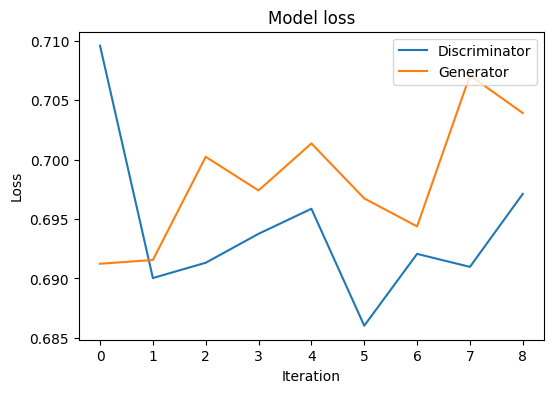

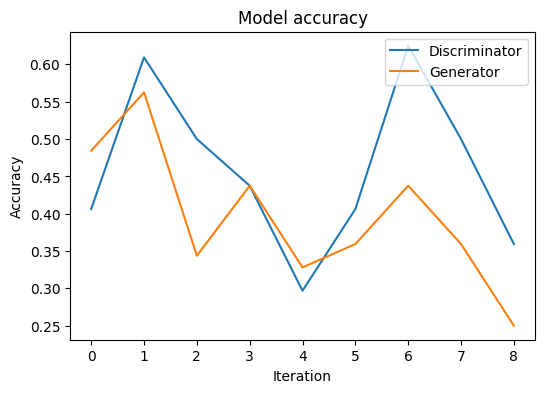

2/2 [==============================] - 0s 12ms/step
>8434, dr[0.705,0.203], df[0.688,0.609], g[0.701,0.391]
2/2 [==============================] - 0s 15ms/step
>8435, dr[0.704,0.328], df[0.685,0.641], g[0.706,0.297]
2/2 [==============================] - 0s 11ms/step
>8436, dr[0.701,0.359], df[0.685,0.625], g[0.712,0.359]
2/2 [==============================] - 0s 22ms/step
>8437, dr[0.703,0.344], df[0.681,0.641], g[0.706,0.344]
2/2 [==============================] - 0s 19ms/step
>8438, dr[0.705,0.328], df[0.679,0.719], g[0.704,0.375]
2/2 [==============================] - 0s 24ms/step
>8439, dr[0.702,0.375], df[0.679,0.641], g[0.704,0.328]
2/2 [==============================] - 0s 13ms/step
>8440, dr[0.706,0.297], df[0.686,0.609], g[0.705,0.250]
2/2 [==============================] - 0s 13ms/step
>8441, dr[0.700,0.312], df[0.684,0.578], g[0.712,0.219]
2/2 [==============================] - 0s 14ms/step
>8442, dr[0.700,0.375], df[0.683,0.719], g[0.702,0.375]
2/2 [=======================

>Saved: model_9370.h5


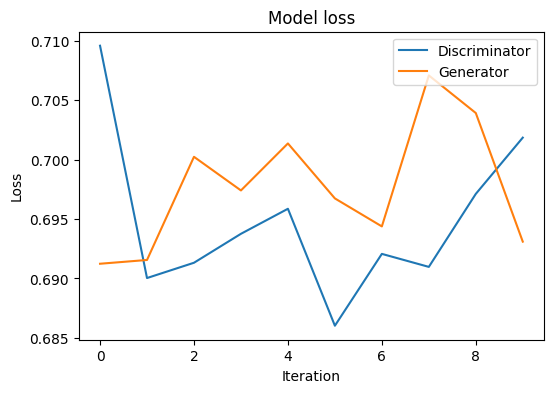

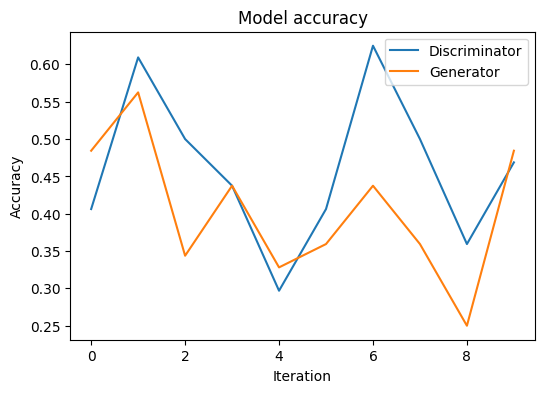

In [45]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dense(128)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dense(64)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()
discriminator.summary()

def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(128, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(64, kernel_initializer=init)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

discriminator = define_discriminator()
discriminator.summary()

gan_model = define_gan(generator, discriminator)
gan_model.summary()

latent_dim = 5
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=64)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


4/4 [==============================] - 0s 6ms/step


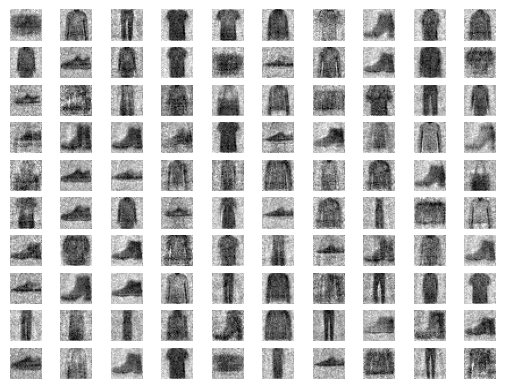

In [47]:
model = load_model('model_1874.h5')
latent_dim = 5
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

***Comment: by increasing epochs to 20, the result be much better than previous version. On the other hand, adding more layer was not good idea because loss error increased and and accuracy of generator grows up.***